<a href="https://colab.research.google.com/github/rinrin528/AIFFEL-1st-Hackathon/blob/main/EDA/EDA_123.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from sklearn import ensemble, neighbors, linear_model, metrics, preprocessing
from datetime import datetime
import glob, re
import time, datetime
from datetime import timedelta

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
color = sns.color_palette()

%matplotlib inline



# tra, ar, hr 데이터를 시각화해보자.

In [2]:
data = {
    'tra': pd.read_csv('/content/drive/MyDrive/data/air_visit_data.csv'),
    'as': pd.read_csv('/content/drive/MyDrive/data/air_store_info.csv'),
    'hs': pd.read_csv('/content/drive/MyDrive/data/hpg_store_info.csv'),
    'ar': pd.read_csv('/content/drive/MyDrive/data/air_reserve.csv'),
    'hr': pd.read_csv('/content/drive/MyDrive/data/hpg_reserve.csv'),
    'id': pd.read_csv('/content/drive/MyDrive/data/store_id_relation.csv'),
    'tes': pd.read_csv('/content/drive/MyDrive/data/sample_submission.csv'),
    'hol': pd.read_csv('/content/drive/MyDrive/data/date_info.csv').rename(columns={'calendar_date':'visit_date'})
    }

data['hr'] = pd.merge(data['hr'], data['id'], how='inner', on=['hpg_store_id'])        # bring air id to hpg reserve data
data['hs'] = pd.merge(data['hs'], data['id'], how='inner', on=['hpg_store_id'])        # bring air id to hpg stores

In [3]:
data['ar']

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5
...,...,...,...,...
92373,air_db4b38ebe7a7ceff,2017-05-29 18:00:00,2017-04-17 19:00:00,6
92374,air_1033310359ceeac1,2017-05-30 23:00:00,2017-04-19 17:00:00,8
92375,air_877f79706adbfb06,2017-05-31 20:00:00,2017-04-12 23:00:00,3
92376,air_900d755ebd2f7bbd,2017-05-31 20:00:00,2017-04-19 16:00:00,10


In [4]:
print('[--------Data structure--------]')
print('Training data: ',data['tra'].shape)
print('Unique store id in training data: ',len(data['tra']['air_store_id'].unique()))
print('Id data: ',data['id'].shape)
print('Air store data: ',data['as'].shape,'& unique-',data['as']['air_store_id'].unique().shape)
print('Hpg store data: ',data['hs'].shape,'& unique-',data['hs']['hpg_store_id'].unique().shape)
print('Air reserve data: ',data['ar'].shape,'& unique-',data['ar']['air_store_id'].unique().shape)
print('Hpg reserve data: ',data['hr'].shape,'& unique-',data['hr']['air_store_id'].unique().shape)

[--------Data structure--------]
Training data:  (252108, 3)
Unique store id in training data:  829
Id data:  (150, 2)
Air store data:  (829, 5) & unique- (829,)
Hpg store data:  (63, 6) & unique- (63,)
Air reserve data:  (92378, 4) & unique- (314,)
Hpg reserve data:  (28183, 5) & unique- (150,)


In [5]:
for df in ['ar', 'hr']:
    data[df]['visit_datetime'] = pd.to_datetime(data[df]['visit_datetime'])
    data[df]['visit_hour'] = data[df]['visit_datetime'].dt.hour
    data[df]['visit_datetime'] = data[df]['visit_datetime'].dt.date


    data[df]['reserve_datetime'] = pd.to_datetime(data[df]['reserve_datetime'])
    data[df]['reserve_hour'] = data[df]['reserve_datetime'].dt.hour
    data[df]['reserve_datetime'] = data[df]['reserve_datetime'].dt.date

    data[df+'_hour'] = data[df]#keeping original

    #calculate reserve time difference and summarizing ar,hr to date
    data[df]['reserve_datetime_diff'] = data[df].apply(
        lambda r: (r['visit_datetime'] - r['reserve_datetime']).days, axis=1)
    display(data[df])
    data[df] = data[df].groupby(
        ['air_store_id', 'visit_datetime'], as_index=False)[[
            'reserve_datetime_diff', 'reserve_visitors'
        ]].sum().rename(columns={
            'visit_datetime': 'visit_date'
        })
    display(data[df])

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,visit_hour,reserve_hour,reserve_datetime_diff
0,air_877f79706adbfb06,2016-01-01,2016-01-01,1,19,16,0
1,air_db4b38ebe7a7ceff,2016-01-01,2016-01-01,3,19,19,0
2,air_db4b38ebe7a7ceff,2016-01-01,2016-01-01,6,19,19,0
3,air_877f79706adbfb06,2016-01-01,2016-01-01,2,20,16,0
4,air_db80363d35f10926,2016-01-01,2016-01-01,5,20,1,0
...,...,...,...,...,...,...,...
92373,air_db4b38ebe7a7ceff,2017-05-29,2017-04-17,6,18,19,42
92374,air_1033310359ceeac1,2017-05-30,2017-04-19,8,23,17,41
92375,air_877f79706adbfb06,2017-05-31,2017-04-12,3,20,23,49
92376,air_900d755ebd2f7bbd,2017-05-31,2017-04-19,10,20,16,42


,air_store_id,visit_date,reserve_datetime_diff,reserve_visitors
0,air_00a91d42b08b08d9,2016-10-31,0,2
1,air_00a91d42b08b08d9,2016-12-05,4,9
2,air_00a91d42b08b08d9,2016-12-14,6,18
3,air_00a91d42b08b08d9,2016-12-17,6,2
4,air_00a91d42b08b08d9,2016-12-20,2,4
...,...,...,...,...
29825,air_fea5dc9594450608,2017-04-22,0,2
29826,air_fea5dc9594450608,2017-04-25,9,2
29827,air_fea5dc9594450608,2017-04-28,29,3
29828,air_fea5dc9594450608,2017-05-20,34,6


,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors,air_store_id,visit_hour,reserve_hour,reserve_datetime_diff
0,hpg_878cc70b1abc76f7,2016-01-01,2016-01-01,4,air_db80363d35f10926,19,15,0
1,hpg_878cc70b1abc76f7,2016-01-02,2016-01-02,2,air_db80363d35f10926,19,14,0
2,hpg_878cc70b1abc76f7,2016-01-03,2016-01-02,6,air_db80363d35f10926,18,20,1
3,hpg_878cc70b1abc76f7,2016-01-06,2016-01-04,3,air_db80363d35f10926,20,22,2
4,hpg_878cc70b1abc76f7,2016-01-11,2016-01-11,2,air_db80363d35f10926,18,14,0
...,...,...,...,...,...,...,...,...
28178,hpg_0f78ef8d1e4b23d8,2017-04-01,2017-03-10,2,air_84f6876ff7e83ae7,21,20,22
28179,hpg_0f78ef8d1e4b23d8,2017-04-02,2017-04-02,2,air_84f6876ff7e83ae7,17,14,0
28180,hpg_0f78ef8d1e4b23d8,2017-04-08,2017-04-03,3,air_84f6876ff7e83ae7,19,12,5
28181,hpg_0f78ef8d1e4b23d8,2017-04-08,2017-03-09,4,air_84f6876ff7e83ae7,20,7,30


,air_store_id,visit_date,reserve_datetime_diff,reserve_visitors
0,air_00a91d42b08b08d9,2016-01-14,3,2
1,air_00a91d42b08b08d9,2016-01-15,6,4
2,air_00a91d42b08b08d9,2016-01-16,3,2
3,air_00a91d42b08b08d9,2016-01-22,3,2
4,air_00a91d42b08b08d9,2016-01-29,6,5
...,...,...,...,...
18615,air_fea5dc9594450608,2017-04-21,2,2
18616,air_fea5dc9594450608,2017-04-22,0,2
18617,air_fea5dc9594450608,2017-04-25,9,2
18618,air_fea5dc9594450608,2017-04-28,29,3


In [6]:
data['ar']

,air_store_id,visit_date,reserve_datetime_diff,reserve_visitors
0,air_00a91d42b08b08d9,2016-10-31,0,2
1,air_00a91d42b08b08d9,2016-12-05,4,9
2,air_00a91d42b08b08d9,2016-12-14,6,18
3,air_00a91d42b08b08d9,2016-12-17,6,2
4,air_00a91d42b08b08d9,2016-12-20,2,4
...,...,...,...,...
29825,air_fea5dc9594450608,2017-04-22,0,2
29826,air_fea5dc9594450608,2017-04-25,9,2
29827,air_fea5dc9594450608,2017-04-28,29,3
29828,air_fea5dc9594450608,2017-05-20,34,6


In [7]:
data['tra']['visit_date'] = pd.to_datetime(data['tra']['visit_date'])    # 날짜 데이터타입으로 변경
data['tra']['dow'] = data['tra']['visit_date'].dt.dayofweek              # 요일 컬럼 생성
data['tra']['year'] = data['tra']['visit_date'].dt.year                  # 년도 컬럼 생성
data['tra']['month'] = data['tra']['visit_date'].dt.month                # month 컬럼 생성
data['tra']['dow_name'] = data['tra']['visit_date'].dt.day_name()

data['tra']['visit_date'] = data['tra']['visit_date'].dt.date
data['tra']['year_mth'] = data['tra']['year'].astype(str)+'-'+data['tra']['month'].astype(str)

In [8]:
data['tes']['visit_date'] = data['tes']['id'].map(
    lambda x: str(x).split('_')[2])
data['tes']['air_store_id'] = data['tes']['id'].map(
    lambda x: '_'.join(x.split('_')[:2]))
data['tes']['visit_date'] = pd.to_datetime(data['tes']['visit_date'])
data['tes']['dow'] = data['tes']['visit_date'].dt.dayofweek
data['tes']['dow_name'] = data['tes']['visit_date'].dt.day_name()
data['tes']['year'] = data['tes']['visit_date'].dt.year
data['tes']['month'] = data['tes']['visit_date'].dt.month

data['tes']['visit_date'] = data['tes']['visit_date'].dt.date
data['tes']['year_mth'] = data['tes']['year'].astype(str)+'-'+data['tes']['month'].astype(str)

In [9]:
#extract unique stores based on test data and populate dow 1 to 6
unique_stores = data['tes']['air_store_id'].unique()
stores = pd.concat(
    [
        pd.DataFrame({
            'air_store_id': unique_stores,
            'dow': [i] * len(unique_stores)
        }) for i in range(7)
    ],
    axis=0,
    ignore_index=True).reset_index(drop=True)
stores

,air_store_id,dow
0,air_00a91d42b08b08d9,0
1,air_0164b9927d20bcc3,0
2,air_0241aa3964b7f861,0
3,air_0328696196e46f18,0
4,air_034a3d5b40d5b1b1,0
...,...,...
5742,air_fea5dc9594450608,6
5743,air_fee8dcf4d619598e,6
5744,air_fef9ccb3ba0da2f7,6
5745,air_ffcc2d5087e1b476,6


In [10]:
# mapping train data dow to stores(test data) - min, mean, median, max, count 
tmp = data['tra'].groupby(
    ['air_store_id', 'dow'],
    as_index=False)['visitors'].min().rename(columns={
        'visitors': 'min_visitors' })
stores = pd.merge(stores, tmp, how='left', on=['air_store_id', 'dow'])

tmp = data['tra'].groupby(
    ['air_store_id', 'dow'],
    as_index=False)['visitors'].mean().rename(columns={
        'visitors': 'mean_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id', 'dow'])

tmp = data['tra'].groupby(
    ['air_store_id', 'dow'],
    as_index=False)['visitors'].median().rename(columns={
        'visitors': 'median_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id', 'dow'])

tmp = data['tra'].groupby(
    ['air_store_id', 'dow'],
    as_index=False)['visitors'].max().rename(columns={
        'visitors': 'max_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id', 'dow'])

tmp = data['tra'].groupby(
    ['air_store_id', 'dow'],
    as_index=False)['visitors'].count().rename(columns={
        'visitors': 'count_observations'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id', 'dow'])

stores

,air_store_id,dow,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations
0,air_00a91d42b08b08d9,0,1.0,22.457143,19.0,47.0,35.0
1,air_0164b9927d20bcc3,0,2.0,7.500000,6.0,19.0,20.0
2,air_0241aa3964b7f861,0,2.0,8.920635,8.0,23.0,63.0
3,air_0328696196e46f18,0,2.0,6.416667,4.0,27.0,12.0
4,air_034a3d5b40d5b1b1,0,1.0,11.864865,10.0,66.0,37.0
...,...,...,...,...,...,...,...
5742,air_fea5dc9594450608,6,4.0,11.634146,9.0,35.0,41.0
5743,air_fee8dcf4d619598e,6,11.0,30.200000,31.5,43.0,40.0
5744,air_fef9ccb3ba0da2f7,6,2.0,10.634146,9.0,30.0,41.0
5745,air_ffcc2d5087e1b476,6,2.0,4.250000,3.5,9.0,8.0


In [11]:
# map stores(test) to store genre and location detail
stores = pd.merge(stores, data['as'], how='left', on=['air_store_id'])

In [12]:
stores

,air_store_id,dow,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations,air_genre_name,air_area_name,latitude,longitude
0,air_00a91d42b08b08d9,0,1.0,22.457143,19.0,47.0,35.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595
1,air_0164b9927d20bcc3,0,2.0,7.500000,6.0,19.0,20.0,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
2,air_0241aa3964b7f861,0,2.0,8.920635,8.0,23.0,63.0,Izakaya,Tōkyō-to Taitō-ku Higashiueno,35.712607,139.779996
3,air_0328696196e46f18,0,2.0,6.416667,4.0,27.0,12.0,Dining bar,Ōsaka-fu Ōsaka-shi Nakanochō,34.701279,135.528090
4,air_034a3d5b40d5b1b1,0,1.0,11.864865,10.0,66.0,37.0,Cafe/Sweets,Ōsaka-fu Ōsaka-shi Ōhiraki,34.692337,135.472229
...,...,...,...,...,...,...,...,...,...,...,...
5742,air_fea5dc9594450608,6,4.0,11.634146,9.0,35.0,41.0,Other,Shizuoka-ken Hamamatsu-shi Motoshirochō,34.710895,137.725940
5743,air_fee8dcf4d619598e,6,11.0,30.200000,31.5,43.0,40.0,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
5744,air_fef9ccb3ba0da2f7,6,2.0,10.634146,9.0,30.0,41.0,Japanese food,Hyōgo-ken Himeji-shi Yasuda,34.815149,134.685353
5745,air_ffcc2d5087e1b476,6,2.0,4.250000,3.5,9.0,8.0,Izakaya,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


In [13]:
lbl = preprocessing.LabelEncoder()
stores['air_genre_name'] = lbl.fit_transform(stores['air_genre_name'])
stores['air_area_name'] = lbl.fit_transform(stores['air_area_name'])

In [14]:
stores

,air_store_id,dow,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations,air_genre_name,air_area_name,latitude,longitude
0,air_00a91d42b08b08d9,0,1.0,22.457143,19.0,47.0,35.0,6,44,35.694003,139.753595
1,air_0164b9927d20bcc3,0,2.0,7.500000,6.0,19.0,20.0,6,62,35.658068,139.751599
2,air_0241aa3964b7f861,0,2.0,8.920635,8.0,23.0,63.0,7,82,35.712607,139.779996
3,air_0328696196e46f18,0,2.0,6.416667,4.0,27.0,12.0,4,98,34.701279,135.528090
4,air_034a3d5b40d5b1b1,0,1.0,11.864865,10.0,66.0,37.0,2,102,34.692337,135.472229
...,...,...,...,...,...,...,...,...,...,...,...
5742,air_fea5dc9594450608,6,4.0,11.634146,9.0,35.0,41.0,11,37,34.710895,137.725940
5743,air_fee8dcf4d619598e,6,11.0,30.200000,31.5,43.0,40.0,6,27,34.695124,135.197852
5744,air_fef9ccb3ba0da2f7,6,2.0,10.634146,9.0,30.0,41.0,8,25,34.815149,134.685353
5745,air_ffcc2d5087e1b476,6,2.0,4.250000,3.5,9.0,8.0,7,62,35.658068,139.751599


In [15]:
data['hol']['visit_date'] = pd.to_datetime(data['hol']['visit_date'])
data['hol']['day_of_week'] = lbl.fit_transform(data['hol']['day_of_week'])
data['hol']['visit_date'] = data['hol']['visit_date'].dt.date

In [16]:
data['hol']

,visit_date,day_of_week,holiday_flg
0,2016-01-01,0,1
1,2016-01-02,2,1
2,2016-01-03,3,1
3,2016-01-04,1,0
4,2016-01-05,5,0
...,...,...,...
512,2017-05-27,2,0
513,2017-05-28,3,0
514,2017-05-29,1,0
515,2017-05-30,5,0


In [17]:
train = pd.merge(data['tra'], data['hol'], how='left', on=['visit_date'])
test = pd.merge(data['tes'], data['hol'], how='left', on=['visit_date'])

train = pd.merge(data['tra'], stores, how='left', on=['air_store_id', 'dow'])
test = pd.merge(data['tes'], stores, how='left', on=['air_store_id', 'dow'])

display(train)
display(test)

,air_store_id,visit_date,visitors,dow,year,month,dow_name,year_mth,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations,air_genre_name,air_area_name,latitude,longitude
0,air_ba937bf13d40fb24,2016-01-13,25,2,2016,1,Wednesday,2016-1,7.0,23.843750,25.0,57.0,64.0,4.0,62.0,35.658068,139.751599
1,air_ba937bf13d40fb24,2016-01-14,32,3,2016,1,Thursday,2016-1,2.0,20.292308,21.0,54.0,65.0,4.0,62.0,35.658068,139.751599
2,air_ba937bf13d40fb24,2016-01-15,29,4,2016,1,Friday,2016-1,4.0,34.738462,35.0,61.0,65.0,4.0,62.0,35.658068,139.751599
3,air_ba937bf13d40fb24,2016-01-16,22,5,2016,1,Saturday,2016-1,6.0,27.651515,27.0,53.0,66.0,4.0,62.0,35.658068,139.751599
4,air_ba937bf13d40fb24,2016-01-18,6,0,2016,1,Monday,2016-1,2.0,13.754386,12.0,34.0,57.0,4.0,62.0,35.658068,139.751599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252103,air_24e8414b9b07decb,2017-04-18,6,1,2017,4,Tuesday,2017-4,2.0,5.615385,6.0,11.0,39.0,11.0,72.0,35.653217,139.711036
252104,air_24e8414b9b07decb,2017-04-19,6,2,2017,4,Wednesday,2017-4,2.0,6.575000,6.0,25.0,40.0,11.0,72.0,35.653217,139.711036
252105,air_24e8414b9b07decb,2017-04-20,7,3,2017,4,Thursday,2017-4,2.0,5.394737,6.0,8.0,38.0,11.0,72.0,35.653217,139.711036
252106,air_24e8414b9b07decb,2017-04-21,8,4,2017,4,Friday,2017-4,2.0,5.738095,6.0,9.0,42.0,11.0,72.0,35.653217,139.711036


,id,visitors,visit_date,air_store_id,dow,dow_name,year,month,year_mth,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations,air_genre_name,air_area_name,latitude,longitude
0,air_00a91d42b08b08d9_2017-04-23,0,2017-04-23,air_00a91d42b08b08d9,6,Sunday,2017,4,2017-4,2.0,2.000000,2.0,2.0,1.0,6,44,35.694003,139.753595
1,air_00a91d42b08b08d9_2017-04-24,0,2017-04-24,air_00a91d42b08b08d9,0,Monday,2017,4,2017-4,1.0,22.457143,19.0,47.0,35.0,6,44,35.694003,139.753595
2,air_00a91d42b08b08d9_2017-04-25,0,2017-04-25,air_00a91d42b08b08d9,1,Tuesday,2017,4,2017-4,1.0,24.350000,24.5,43.0,40.0,6,44,35.694003,139.753595
3,air_00a91d42b08b08d9_2017-04-26,0,2017-04-26,air_00a91d42b08b08d9,2,Wednesday,2017,4,2017-4,15.0,28.125000,28.0,52.0,40.0,6,44,35.694003,139.753595
4,air_00a91d42b08b08d9_2017-04-27,0,2017-04-27,air_00a91d42b08b08d9,3,Thursday,2017,4,2017-4,15.0,29.868421,30.0,47.0,38.0,6,44,35.694003,139.753595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32014,air_fff68b929994bfbd_2017-05-27,0,2017-05-27,air_fff68b929994bfbd,5,Saturday,2017,5,2017-5,2.0,7.439024,7.0,18.0,41.0,1,65,35.708146,139.666288
32015,air_fff68b929994bfbd_2017-05-28,0,2017-05-28,air_fff68b929994bfbd,6,Sunday,2017,5,2017-5,1.0,4.000000,3.5,10.0,30.0,1,65,35.708146,139.666288
32016,air_fff68b929994bfbd_2017-05-29,0,2017-05-29,air_fff68b929994bfbd,0,Monday,2017,5,2017-5,1.0,4.200000,4.0,14.0,35.0,1,65,35.708146,139.666288
32017,air_fff68b929994bfbd_2017-05-30,0,2017-05-30,air_fff68b929994bfbd,1,Tuesday,2017,5,2017-5,1.0,4.526316,4.0,11.0,38.0,1,65,35.708146,139.666288


In [18]:
for df in ['ar', 'hr']:
    train = pd.merge(
        train, data[df], how='left', on=['air_store_id', 'visit_date'])
    test = pd.merge(
        test, data[df], how='left', on=['air_store_id', 'visit_date'])

In [19]:
display(train)
display(test)

,air_store_id,visit_date,visitors,dow,year,month,dow_name,year_mth,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations,air_genre_name,air_area_name,latitude,longitude,reserve_datetime_diff_x,reserve_visitors_x,reserve_datetime_diff_y,reserve_visitors_y
0,air_ba937bf13d40fb24,2016-01-13,25,2,2016,1,Wednesday,2016-1,7.0,23.843750,25.0,57.0,64.0,4.0,62.0,35.658068,139.751599,NaN,NaN,NaN,NaN
1,air_ba937bf13d40fb24,2016-01-14,32,3,2016,1,Thursday,2016-1,2.0,20.292308,21.0,54.0,65.0,4.0,62.0,35.658068,139.751599,NaN,NaN,NaN,NaN
2,air_ba937bf13d40fb24,2016-01-15,29,4,2016,1,Friday,2016-1,4.0,34.738462,35.0,61.0,65.0,4.0,62.0,35.658068,139.751599,NaN,NaN,NaN,NaN
3,air_ba937bf13d40fb24,2016-01-16,22,5,2016,1,Saturday,2016-1,6.0,27.651515,27.0,53.0,66.0,4.0,62.0,35.658068,139.751599,NaN,NaN,NaN,NaN
4,air_ba937bf13d40fb24,2016-01-18,6,0,2016,1,Monday,2016-1,2.0,13.754386,12.0,34.0,57.0,4.0,62.0,35.658068,139.751599,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252103,air_24e8414b9b07decb,2017-04-18,6,1,2017,4,Tuesday,2017-4,2.0,5.615385,6.0,11.0,39.0,11.0,72.0,35.653217,139.711036,NaN,NaN,NaN,NaN
252104,air_24e8414b9b07decb,2017-04-19,6,2,2017,4,Wednesday,2017-4,2.0,6.575000,6.0,25.0,40.0,11.0,72.0,35.653217,139.711036,NaN,NaN,NaN,NaN
252105,air_24e8414b9b07decb,2017-04-20,7,3,2017,4,Thursday,2017-4,2.0,5.394737,6.0,8.0,38.0,11.0,72.0,35.653217,139.711036,NaN,NaN,NaN,NaN
252106,air_24e8414b9b07decb,2017-04-21,8,4,2017,4,Friday,2017-4,2.0,5.738095,6.0,9.0,42.0,11.0,72.0,35.653217,139.711036,NaN,NaN,NaN,NaN


,id,visitors,visit_date,air_store_id,dow,dow_name,year,month,year_mth,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations,air_genre_name,air_area_name,latitude,longitude,reserve_datetime_diff_x,reserve_visitors_x,reserve_datetime_diff_y,reserve_visitors_y
0,air_00a91d42b08b08d9_2017-04-23,0,2017-04-23,air_00a91d42b08b08d9,6,Sunday,2017,4,2017-4,2.0,2.000000,2.0,2.0,1.0,6,44,35.694003,139.753595,NaN,NaN,NaN,NaN
1,air_00a91d42b08b08d9_2017-04-24,0,2017-04-24,air_00a91d42b08b08d9,0,Monday,2017,4,2017-4,1.0,22.457143,19.0,47.0,35.0,6,44,35.694003,139.753595,NaN,NaN,NaN,NaN
2,air_00a91d42b08b08d9_2017-04-25,0,2017-04-25,air_00a91d42b08b08d9,1,Tuesday,2017,4,2017-4,1.0,24.350000,24.5,43.0,40.0,6,44,35.694003,139.753595,NaN,NaN,NaN,NaN
3,air_00a91d42b08b08d9_2017-04-26,0,2017-04-26,air_00a91d42b08b08d9,2,Wednesday,2017,4,2017-4,15.0,28.125000,28.0,52.0,40.0,6,44,35.694003,139.753595,NaN,NaN,NaN,NaN
4,air_00a91d42b08b08d9_2017-04-27,0,2017-04-27,air_00a91d42b08b08d9,3,Thursday,2017,4,2017-4,15.0,29.868421,30.0,47.0,38.0,6,44,35.694003,139.753595,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32014,air_fff68b929994bfbd_2017-05-27,0,2017-05-27,air_fff68b929994bfbd,5,Saturday,2017,5,2017-5,2.0,7.439024,7.0,18.0,41.0,1,65,35.708146,139.666288,NaN,NaN,NaN,NaN
32015,air_fff68b929994bfbd_2017-05-28,0,2017-05-28,air_fff68b929994bfbd,6,Sunday,2017,5,2017-5,1.0,4.000000,3.5,10.0,30.0,1,65,35.708146,139.666288,NaN,NaN,NaN,NaN
32016,air_fff68b929994bfbd_2017-05-29,0,2017-05-29,air_fff68b929994bfbd,0,Monday,2017,5,2017-5,1.0,4.200000,4.0,14.0,35.0,1,65,35.708146,139.666288,NaN,NaN,NaN,NaN
32017,air_fff68b929994bfbd_2017-05-30,0,2017-05-30,air_fff68b929994bfbd,1,Tuesday,2017,5,2017-5,1.0,4.526316,4.0,11.0,38.0,1,65,35.708146,139.666288,NaN,NaN,NaN,NaN


In [20]:
train = train.fillna(-1)
test = test.fillna(-1)

In [21]:
print(len(stores.groupby(['latitude','longitude'])['latitude','longitude'].size().reset_index()), 'physical stores')

108 physical stores


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [22]:
import folium
from folium import plugins

location =stores.groupby(['latitude', 'longitude']).size().reset_index()
locationheat = location[['latitude', 'longitude']]
locationheat = locationheat.values.tolist()

map1 = folium.Map(location=[39, 139], 
                        tiles = "Stamen Watercolor",# width=1000, height=500,
                        zoom_start = 5)
heatmap=plugins.HeatMap(locationheat).add_to(map1)
map1


In [23]:
data['as']

,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
...,...,...,...,...,...
824,air_9bf595ef095572fb,International cuisine,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051
825,air_764f71040a413d4d,Asian,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051
826,air_10bbe8acd943d8f6,Asian,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051
827,air_7514d90009613cd6,Karaoke/Party,Hokkaidō Sapporo-shi Minami 3 Jōnishi,43.055460,141.340956


In [24]:
location =stores.groupby(['air_store_id','air_genre_name'])['latitude','longitude'].mean().reset_index()
locationlist = location[['latitude', 'longitude']]
locationlist = locationlist.values.tolist()
map2 = folium.Map(location=[39, 139], 
                        tiles = "Stamen Toner",# width=1000, height=500,
                        zoom_start = 5)
marker_cluster=plugins.MarkerCluster().add_to(map2)
for point in range(0, len(location)):
    folium.Marker(locationlist[point],
    icon=folium.Icon(color='white', icon_color='red', 
                     #icon='fa fa-info-circle',
                     icon='fa fa-circle-o-notch fa-spin',
                     angle=0, 
                     prefix='fa')).add_to(marker_cluster)
map2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


# air_visit_data 시각화
data['tra']

train

In [25]:
data['tra']['visitors'].max()

877

In [26]:
data['tra']

,air_store_id,visit_date,visitors,dow,year,month,dow_name,year_mth
0,air_ba937bf13d40fb24,2016-01-13,25,2,2016,1,Wednesday,2016-1
1,air_ba937bf13d40fb24,2016-01-14,32,3,2016,1,Thursday,2016-1
2,air_ba937bf13d40fb24,2016-01-15,29,4,2016,1,Friday,2016-1
3,air_ba937bf13d40fb24,2016-01-16,22,5,2016,1,Saturday,2016-1
4,air_ba937bf13d40fb24,2016-01-18,6,0,2016,1,Monday,2016-1
...,...,...,...,...,...,...,...,...
252103,air_24e8414b9b07decb,2017-04-18,6,1,2017,4,Tuesday,2017-4
252104,air_24e8414b9b07decb,2017-04-19,6,2,2017,4,Wednesday,2017-4
252105,air_24e8414b9b07decb,2017-04-20,7,3,2017,4,Thursday,2017-4
252106,air_24e8414b9b07decb,2017-04-21,8,4,2017,4,Friday,2017-4


In [27]:
train

,air_store_id,visit_date,visitors,dow,year,month,dow_name,year_mth,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations,air_genre_name,air_area_name,latitude,longitude,reserve_datetime_diff_x,reserve_visitors_x,reserve_datetime_diff_y,reserve_visitors_y
0,air_ba937bf13d40fb24,2016-01-13,25,2,2016,1,Wednesday,2016-1,7.0,23.843750,25.0,57.0,64.0,4.0,62.0,35.658068,139.751599,-1.0,-1.0,-1.0,-1.0
1,air_ba937bf13d40fb24,2016-01-14,32,3,2016,1,Thursday,2016-1,2.0,20.292308,21.0,54.0,65.0,4.0,62.0,35.658068,139.751599,-1.0,-1.0,-1.0,-1.0
2,air_ba937bf13d40fb24,2016-01-15,29,4,2016,1,Friday,2016-1,4.0,34.738462,35.0,61.0,65.0,4.0,62.0,35.658068,139.751599,-1.0,-1.0,-1.0,-1.0
3,air_ba937bf13d40fb24,2016-01-16,22,5,2016,1,Saturday,2016-1,6.0,27.651515,27.0,53.0,66.0,4.0,62.0,35.658068,139.751599,-1.0,-1.0,-1.0,-1.0
4,air_ba937bf13d40fb24,2016-01-18,6,0,2016,1,Monday,2016-1,2.0,13.754386,12.0,34.0,57.0,4.0,62.0,35.658068,139.751599,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252103,air_24e8414b9b07decb,2017-04-18,6,1,2017,4,Tuesday,2017-4,2.0,5.615385,6.0,11.0,39.0,11.0,72.0,35.653217,139.711036,-1.0,-1.0,-1.0,-1.0
252104,air_24e8414b9b07decb,2017-04-19,6,2,2017,4,Wednesday,2017-4,2.0,6.575000,6.0,25.0,40.0,11.0,72.0,35.653217,139.711036,-1.0,-1.0,-1.0,-1.0
252105,air_24e8414b9b07decb,2017-04-20,7,3,2017,4,Thursday,2017-4,2.0,5.394737,6.0,8.0,38.0,11.0,72.0,35.653217,139.711036,-1.0,-1.0,-1.0,-1.0
252106,air_24e8414b9b07decb,2017-04-21,8,4,2017,4,Friday,2017-4,2.0,5.738095,6.0,9.0,42.0,11.0,72.0,35.653217,139.711036,-1.0,-1.0,-1.0,-1.0


In [28]:
data['tra']['month'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

## (air로 집계한) 월별 방문자 수

Text(0.5, 1.0, 'Visitors')

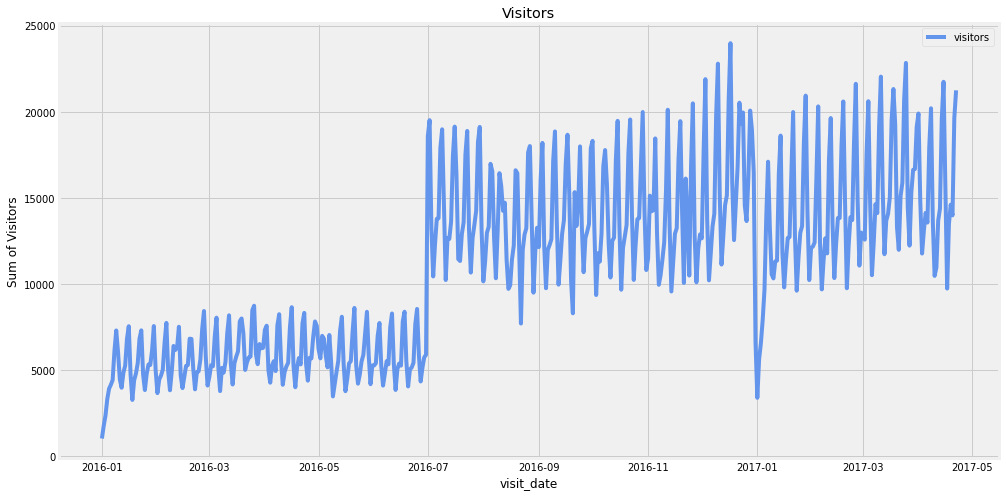

In [29]:
#Visitor each day
f,ax = plt.subplots(1,1,figsize=(15,8))

plt1 = data['tra'].groupby(['visit_date'], as_index=False).agg({'visitors': np.sum})
plt1=plt1.set_index('visit_date')
plt1.plot(color='cornflowerblue', kind='line', ax=ax)

plt.ylabel("Sum of Visitors")
plt.title("Visitors")

## 요일별 평균 방문자 수

In [30]:
df = data['tra'].groupby('dow_name').mean().drop(['year', 'month', 'dow'], axis=1)
df

,visitors
dow_name,
Friday,23.072737
Monday,17.177009
Saturday,26.313688
Sunday,23.873362
Thursday,18.922702
Tuesday,17.672137
Wednesday,19.230121


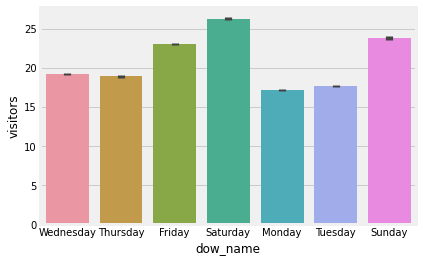

In [31]:
fig = plt.figure()

sns.barplot(x='dow_name', y='visitors', data=data['tra'])

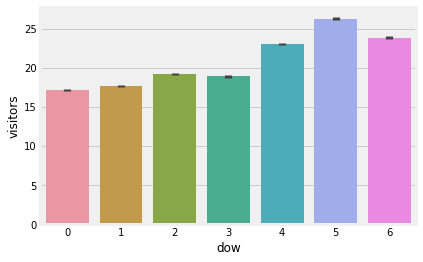

In [32]:
fig = plt.figure()

sns.barplot(x='dow', y='visitors', data=data['tra'])

## 방문자 수 빈도 

[[Python] Python에서 R ggplot2 함수로 그래프 그리기 (by PlotNine library)](https://rfriend.tistory.com/420)

<Figure size 432x288 with 0 Axes>

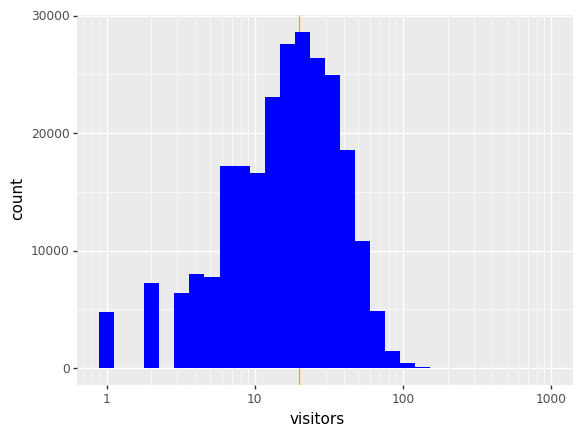

<ggplot: (8774786027841)>

In [33]:
from plotnine import *

fig = plt.figure()

ggplot(data['tra'], aes('visitors')) +\
  geom_vline(xintercept = 20, color = 'orange') +\
  geom_histogram(fill = 'blue', bins = 30) +\
  scale_x_log10()

In [34]:
data['tra'].groupby('month').mean()

,visitors,dow,year
month,,,
1,19.976758,3.039378,2016.729090
2,20.477695,2.974685,2016.722634
3,22.400360,2.994930,2016.729212
4,21.816002,3.102519,2016.660967
5,22.009313,2.941306,2016.000000
6,21.319510,2.965806,2016.000000
7,21.267653,3.210949,2016.000000
8,19.748489,2.824087,2016.000000
9,19.908445,3.065198,2016.000000


[Seaborn으로 히트맵 그리기](https://dsbook.tistory.com/51)

[Pandas - pivot_table, Seaborn](https://essim92.tistory.com/48)

In [ ]:
data['ar']

In [ ]:
sns.heatmap(df)

In [ ]:
sns.histplot(x=data['tra']['dow'], y=data['tra']['visitors'])
sns.set(rc = {'figure.figsize':(15,10)})

In [ ]:
from plotnine import *

fig = plt.figure()

ggplot(data['tra'], aes(x='visit_date', y='visitors', group='month', color='month')) \
    + geom_line() \
    + ggtitle('Time Series Graph of Visitors') \
    + labs(y = 'Visitors', x = 'Date')

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/recruit-restaurant-visitor-forecasting/air_reserve.csv.zip
/kaggle/input/recruit-restaurant-visitor-forecasting/hpg_store_info.csv.zip
/kaggle/input/recruit-restaurant-visitor-forecasting/hpg_reserve.csv.zip
/kaggle/input/recruit-restaurant-visitor-forecasting/sample_submission.csv.zip
/kaggle/input/recruit-restaurant-visitor-forecasting/air_visit_data.csv.zip
/kaggle/input/recruit-restaurant-visitor-forecasting/air_store_info.csv.zip
/kaggle/input/recruit-restaurant-visitor-forecasting/date_info.csv.zip
/kaggle/input/recruit-restaurant-visitor-forecasting/store_id_relation.csv.zip


In [ ]:
import matplotlib.font_manager as fm

In [96]:
# 한글 폰트 설정
!apt-get install -y fonts-nanum
!ls -l /usr/share/fonts/truetype/
!rm -rf ~/.cache/matplotlib/*
!fc-cache -fv

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 8 not upgraded.
Need to get 9604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9604 kB]
Fetched 9604 kB in 2s (4841 kB/s)      
debconf: delaying package configuration, since apt-utils is not installed
Selecting previously unselected package fonts-nanum.
(Reading database ... 96799 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...
total 8
drwxr-xr-x 1 root root 4096 Jun 19 05:07 dejavu
drwxr-xr-x 2 root root 4096 Aug  5 02:59 nanum
/usr/share/fonts: caching, new cache content

In [102]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_palette('husl',9)
%matplotlib inline
font_path = '/kaggle/input/nanumgothic/NanumGothic.ttf'
plt.rcParams['axes.unicode_minus']=False
font_name=fm.FontProperties(fname=font_path,size=10)
plt.rcParams['font.family']=font_name.get_name()

In [105]:
plt.rcParams['font.family']

['NanumGothic']

# 데이터 불러오기

In [83]:
dir_path = '/kaggle/input/recruit-restaurant-visitor-forecasting/'
data = {
    'tra':
    pd.read_csv(dir_path+'air_visit_data.csv.zip'),
    'as':
    pd.read_csv(dir_path+'air_store_info.csv.zip'),
    'hs':
    pd.read_csv(dir_path+'hpg_store_info.csv.zip'),
    'ar':
    pd.read_csv(dir_path+'air_reserve.csv.zip'),
    'hr':
    pd.read_csv(dir_path+'hpg_reserve.csv.zip'),
    'id':
    pd.read_csv(dir_path+'store_id_relation.csv.zip'),
    'tes':
    pd.read_csv(dir_path+'sample_submission.csv.zip'),
    'hol':
    pd.read_csv(dir_path+'date_info.csv.zip').rename(columns={
        'calendar_date': 'visit_date'
    })
}

### 원활한 시각화를 위한 날짜 컬럼 추가

## air_store_info
- air에는 총 829개의 가게 정보가 존재한다.

In [3]:
data['as'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829 entries, 0 to 828
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   air_store_id    829 non-null    object 
 1   air_genre_name  829 non-null    object 
 2   air_area_name   829 non-null    object 
 3   latitude        829 non-null    float64
 4   longitude       829 non-null    float64
dtypes: float64(2), object(3)
memory usage: 32.5+ KB


- air는 총 14개의 종류로 식당을 분류하고 있다.
- air에서 포괄하고 있는 지역은 103개이다.

In [20]:
data['as'].nunique()

air_store_id      829
air_genre_name     14
air_area_name     103
latitude          108
longitude         108
dtype: int64

### 지역별 가게 장르 분포

- 지역의 개수가 많으므로 상위 10개 지역에서의 장르 분포와 더 넓은 단위의 지역별 장르 분포를 보자

In [40]:
air_top_10 = data['as'].iloc[:,0:3].groupby('air_area_name').count().sort_values(by='air_store_id',ascending=False).head(10)

,air_store_id,air_genre_name
air_area_name,,
Fukuoka-ken Fukuoka-shi Daimyō,64,64
Tōkyō-to Shibuya-ku Shibuya,58,58
Tōkyō-to Minato-ku Shibakōen,51,51
Tōkyō-to Shinjuku-ku Kabukichō,39,39
Tōkyō-to Setagaya-ku Setagaya,30,30
Tōkyō-to Chūō-ku Tsukiji,29,29
Ōsaka-fu Ōsaka-shi Ōgimachi,25,25
Hiroshima-ken Hiroshima-shi Kokutaijimachi,23,23
Tōkyō-to Meguro-ku Kamimeguro,22,22


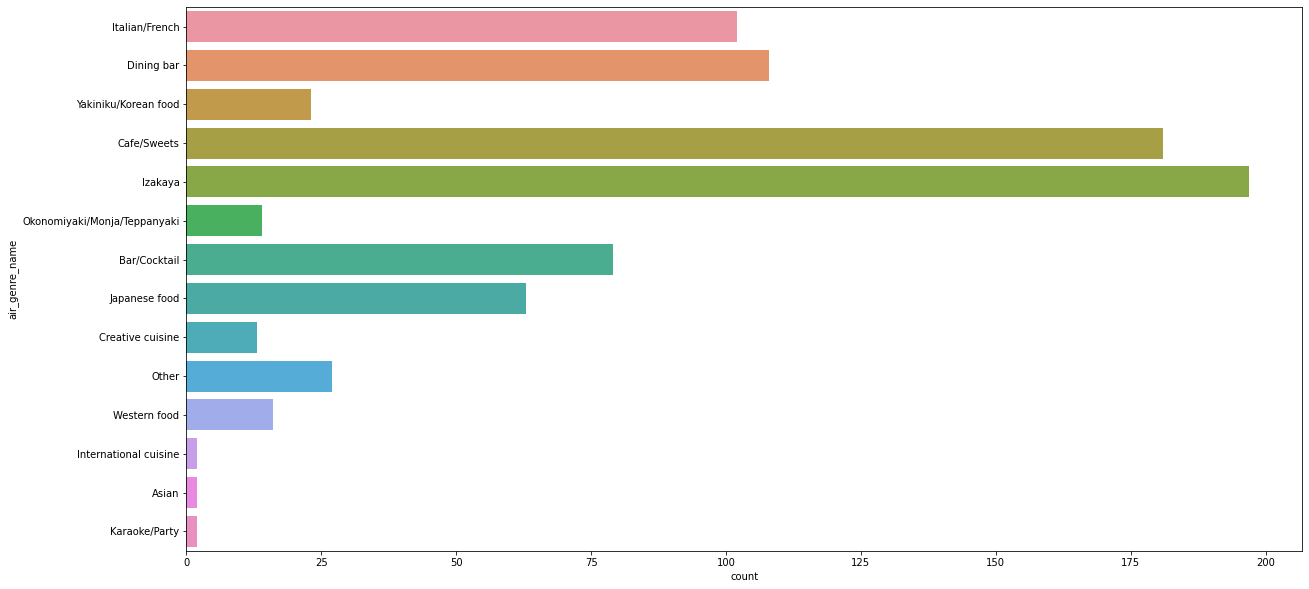

In [65]:
plt.figure(figsize=(20,10))
sns.countplot(y=data['as']['air_genre_name'])
plt.show()

<Figure size 864x720 with 0 Axes>

<AxesSubplot:ylabel='air_genre_name'>

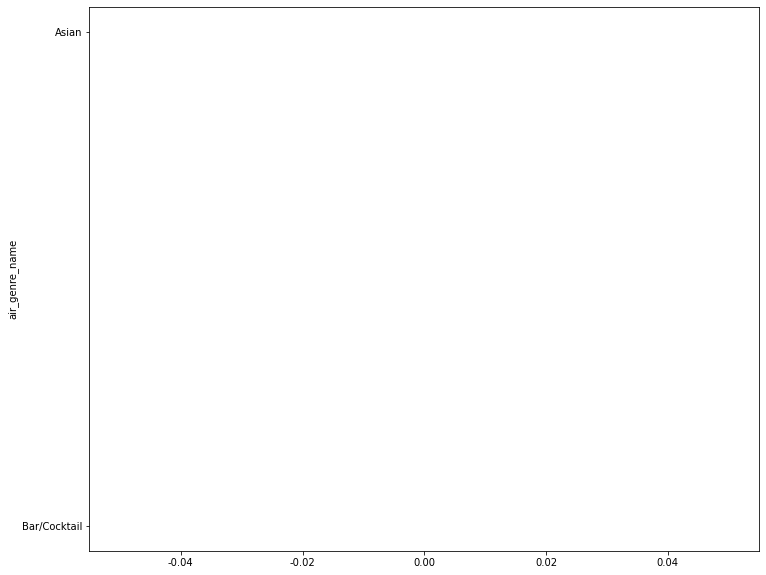

In [165]:
plt.figure(figsize=(12,10))
sns.scatterplot(data=data['as'].groupby('air_genre_name').count(),
           y='air_genre_name')
plt.show()

### 넓은 지역별 가게 정보 보기

- 단순 `air_area_name`으로만 보면 컬럼 수가 너무 많아서 한눈에 보기 어렵다.

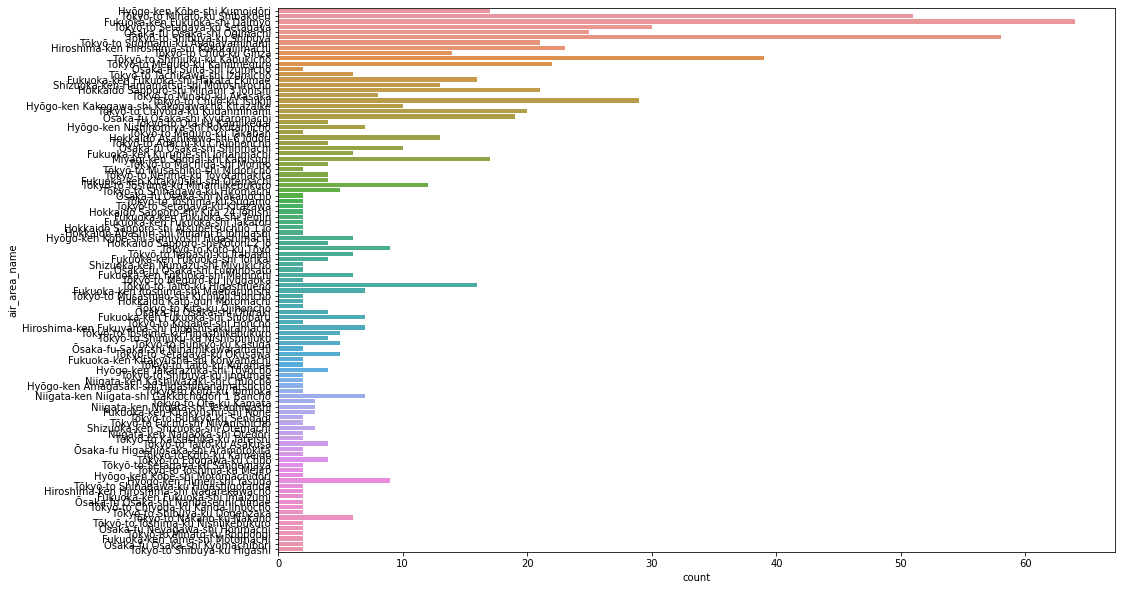

In [76]:
plt.figure(figsize=(15,10))
sns.countplot(y=data['as']['air_area_name'])
plt.show()

- `air_area_name`는 크게 도/도/부/현, 시/구, 동으로 나뉜다.
- 우선 대단위로 그룹화해서 시각화해보자.

In [70]:
data['as']['air_area_name'].sample(10)

748    Fukuoka-ken Fukuoka-shi Momochi
48              Tōkyō-to Chūō-ku Ginza
219        Tōkyō-to Shibuya-ku Shibuya
381        Tōkyō-to Koganei-shi Honchō
518     Miyagi-ken Sendai-shi Kamisugi
432    Hokkaidō Asahikawa-shi 6 Jōdōri
112       Tōkyō-to Minato-ku Shibakōen
781     Fukuoka-ken Fukuoka-shi Daimyō
45              Tōkyō-to Chūō-ku Ginza
235       Tōkyō-to Minato-ku Shibakōen
Name: air_area_name, dtype: object

- 도도부현 정보 칼럼 추가

In [84]:
data['as']['dodo']=data['as']['air_area_name'].apply(lambda x:x.split(' ')[0])

In [73]:
data['as'].head()

,air_store_id,air_genre_name,air_area_name,latitude,longitude,dodo
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,Hyōgo-ken
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,Hyōgo-ken
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,Hyōgo-ken
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,Hyōgo-ken
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Tōkyō-to


- 도쿄 지역의 가게가 월등히 많은 것을 알 수 있고 그 뒤를 후쿠오카와 오사카가 잇고 있다.

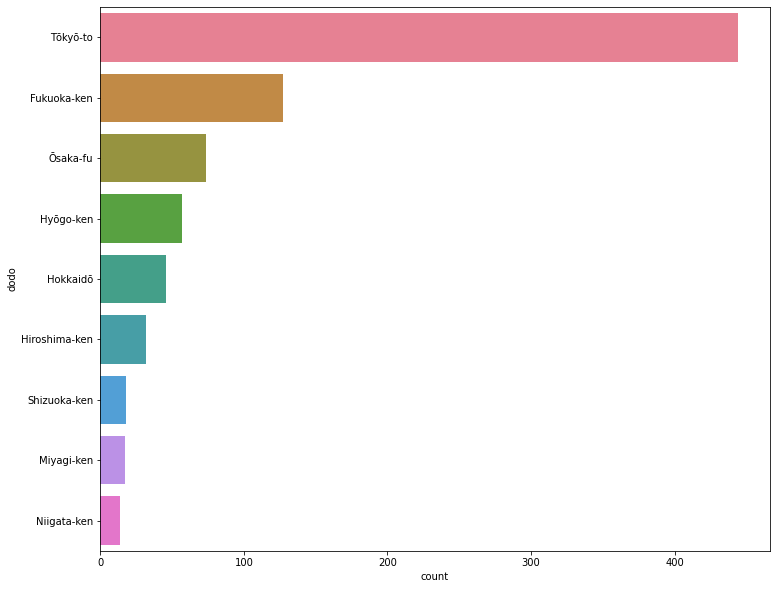

In [77]:
plt.figure(figsize=(12,10))
sns.countplot(y=data['as']['dodo'],
             order=data['as']['dodo'].value_counts().index)
plt.show()

- 시구의 정보까지 뽑아보자.

In [87]:
data['as']['sigu']=data['as']['air_area_name'].apply(lambda x:' '.join(x.split(' ')[:2]))
data['as'].head()
data['as'].nunique()

,air_store_id,air_genre_name,air_area_name,latitude,longitude,dodo,sigu
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,Hyōgo-ken,Hyōgo-ken Kōbe-shi
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,Hyōgo-ken,Hyōgo-ken Kōbe-shi
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,Hyōgo-ken,Hyōgo-ken Kōbe-shi
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,Hyōgo-ken,Hyōgo-ken Kōbe-shi
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Tōkyō-to,Tōkyō-to Minato-ku


air_store_id      829
air_genre_name     14
air_area_name     103
latitude          108
longitude         108
dodo                9
sigu               55
dtype: int64

- 시/구 단위로 넘어오면서 컬럼 개수가 55개로 많아졌으므로 상위 25개만 보도록 하자.

<Figure size 864x720 with 0 Axes>

<AxesSubplot:xlabel='count', ylabel='sigu'>

Text(0.5, 1.0, 'Top 25 Sigu-wise Store Count')

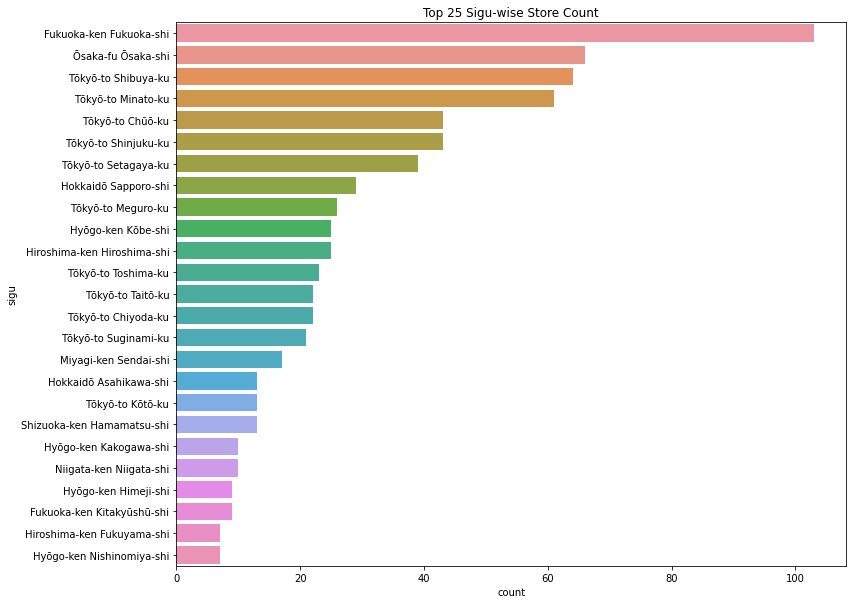

In [107]:
plt.figure(figsize=(12,10))
sns.countplot(y=data['as']['sigu'],
             order=data['as']['sigu'].value_counts().iloc[:25].index)
plt.title('Top 25 Sigu-wise Store Count')
plt.show()

- 시/구 단위로 가장 많은 점포수를 보유한 곳은 후쿠오카시였다. 그 뒤를 오사카시와 시부야구가 뒤를 이었다.

## hpg_store_info

- hpg에는 총 4690개 점포가 입점되어 있다.

In [108]:
data['hs'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4690 entries, 0 to 4689
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   hpg_store_id    4690 non-null   object 
 1   hpg_genre_name  4690 non-null   object 
 2   hpg_area_name   4690 non-null   object 
 3   latitude        4690 non-null   float64
 4   longitude       4690 non-null   float64
dtypes: float64(2), object(3)
memory usage: 183.3+ KB


- hpg는 총 34개의 종류로 식당을 분류하고 있다.
- hpg에서 포괄하고 있는 지역은 129개이다.

In [109]:
data['hs'].nunique()

hpg_store_id      4690
hpg_genre_name      34
hpg_area_name      119
latitude           129
longitude          129
dtype: int64

In [111]:
hpg_top_10 = data['hs'].iloc[:,0:3].groupby('hpg_area_name').count().sort_values(by='hpg_store_id',ascending=False).head(10)

- 장르 중에서 유의미한 점포 개수를 보유하고 있는 장르 수가 10개 내외이다.
- 또한 대부분의 장르가 `Japanese Style`으로 구분되어서

<Figure size 1440x720 with 0 Axes>

<AxesSubplot:xlabel='count', ylabel='hpg_genre_name'>

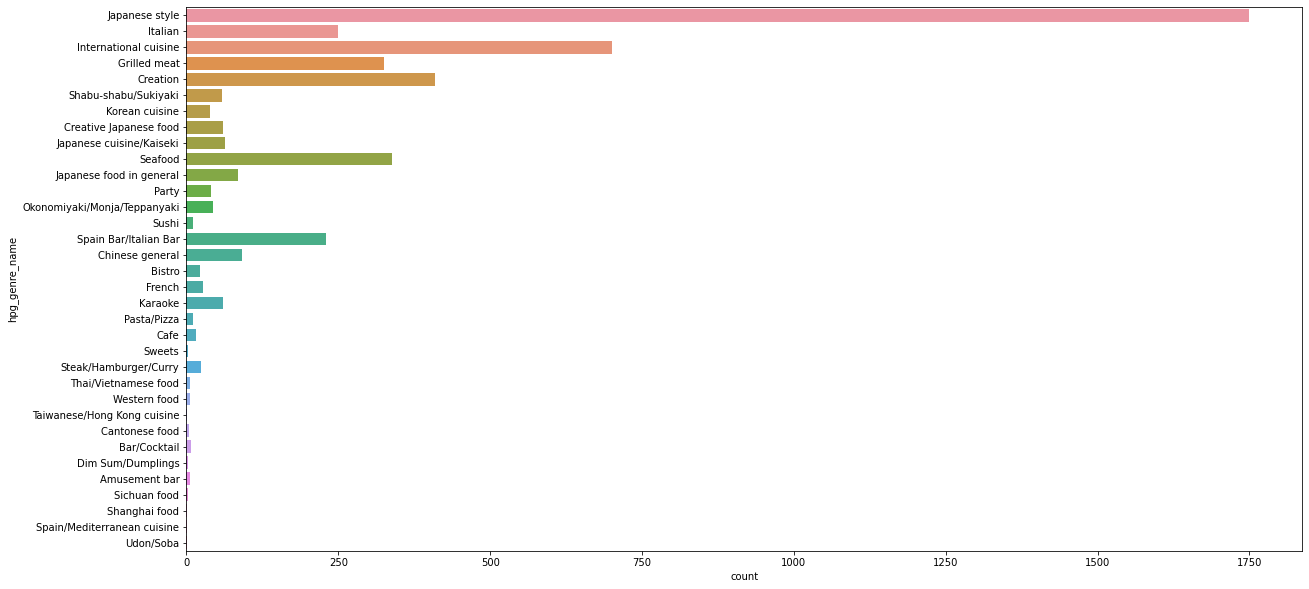

In [112]:
plt.figure(figsize=(20,10))
sns.countplot(y=data['hs']['hpg_genre_name'])
plt.show()

In [115]:
data['hs']['dodo']=data['hs']['hpg_area_name'].apply(lambda x:x.split(' ')[0])
data['hs'].head()

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude,dodo
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221,Tōkyō-to
1,hpg_e9e068dd49c5fa00,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221,Tōkyō-to
2,hpg_2976f7acb4b3a3bc,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221,Tōkyō-to
3,hpg_e51a522e098f024c,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221,Tōkyō-to
4,hpg_e3d0e1519894f275,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221,Tōkyō-to


- hpg에서 눈여겨볼 점은 도쿄와 다른 지역이 월등히 차이가 있으며
- 후쿠오카와 오사카의 순위가 바뀐 것 이외에 큰 변화는 없다.
- air에서 보지 못했던 None이 발생했다.

<Figure size 864x720 with 0 Axes>

<AxesSubplot:xlabel='count', ylabel='dodo'>

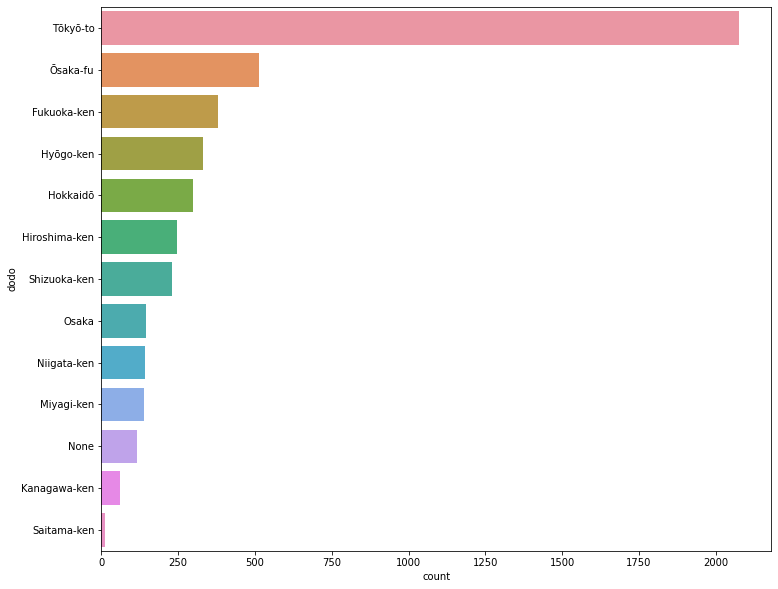

In [116]:
plt.figure(figsize=(12,10))
sns.countplot(y=data['hs']['dodo'],
             order=data['hs']['dodo'].value_counts().index)
plt.show()

- 실제 지역 이름과 위도, 경도가 입력되지 않은 채 `store_id`만 있는 정보가 약 117개가 있었다.

In [120]:
data['hs']['dodo'].unique()

array(['Tōkyō-to', 'Hyōgo-ken', 'Fukuoka-ken', 'Hiroshima-ken',
       'Ōsaka-fu', 'Shizuoka-ken', 'None', 'Kanagawa-ken', 'Hokkaidō',
       'Miyagi-ken', 'Niigata-ken', 'Osaka', 'Saitama-ken'], dtype=object)

In [123]:
data['hs'][data['hs']['dodo']=='None'].head()
len(data['hs'][data['hs']['dodo']=='None'])

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude,dodo,sigu
651,hpg_5fea90674a2185a0,Japanese style,None None None,35.703381,139.660343,None,None None
652,hpg_03d5b644f759a72a,Japanese style,None None None,35.703381,139.660343,None,None None
653,hpg_0bf592f4c532d843,Japanese style,None None None,35.703381,139.660343,None,None None
654,hpg_a11c66d3ce9a8c13,Japanese style,None None None,35.703381,139.660343,None,None None
655,hpg_5cb7bac2842ca8f5,Japanese style,None None None,35.703381,139.660343,None,None None


117

- 시구 정보를 추출한 칼럼을 추가하자

In [124]:
data['hs']['sigu']=data['hs']['hpg_area_name'].apply(lambda x:' '.join(x.split(' ')[:2]))
data['hs'].head()
data['hs'].nunique()

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude,dodo,sigu
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221,Tōkyō-to,Tōkyō-to Setagaya-ku
1,hpg_e9e068dd49c5fa00,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221,Tōkyō-to,Tōkyō-to Setagaya-ku
2,hpg_2976f7acb4b3a3bc,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221,Tōkyō-to,Tōkyō-to Setagaya-ku
3,hpg_e51a522e098f024c,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221,Tōkyō-to,Tōkyō-to Setagaya-ku
4,hpg_e3d0e1519894f275,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221,Tōkyō-to,Tōkyō-to Setagaya-ku


hpg_store_id      4690
hpg_genre_name      34
hpg_area_name      119
latitude           129
longitude          129
dodo                13
sigu                73
dtype: int64

- hpg 가맹 점포는 상대적으로 오사카와 도쿄에 더 

<Figure size 864x720 with 0 Axes>

<AxesSubplot:xlabel='count', ylabel='sigu'>

Text(0.5, 1.0, 'Top 25 Sigu-wise Store Count')

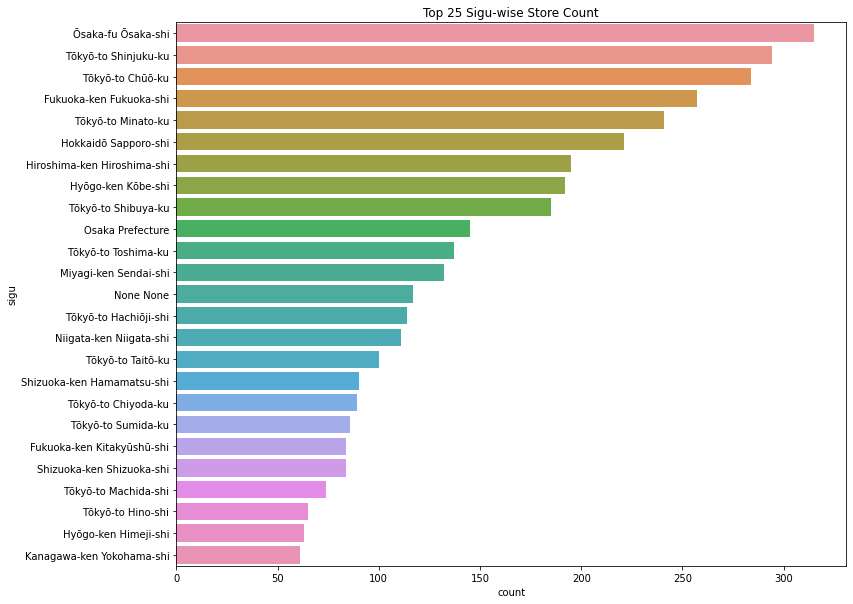

In [125]:
plt.figure(figsize=(12,10))
sns.countplot(y=data['hs']['sigu'],
             order=data['hs']['sigu'].value_counts().iloc[:25].index)
plt.title('Top 25 Sigu-wise Store Count')
plt.show()

- air에 비해 후쿠오카시 소재 가게의 비율이 낮은 편이다. 지역 정보가 없는 정보도 다수 존재한다.

## 지역별 방문자수, 예약자수

In [167]:
visit = pd.merge(data['tra'],data['as'])
visit.sample(10)
visit.nunique()
visit.isnull().sum()

,air_store_id,visit_date,visitors,air_genre_name,air_area_name,latitude,longitude,dodo,sigu
113874,air_6d65542aa43b598b,2017-01-06,15,Italian/French,Shizuoka-ken Hamamatsu-shi Motoshirochō,34.710895,137.725940,Shizuoka-ken,Shizuoka-ken Hamamatsu-shi
230124,air_1979eaff8189d086,2017-02-24,19,Dining bar,Tōkyō-to Tachikawa-shi Izumichō,35.714014,139.407843,Tōkyō-to,Tōkyō-to Tachikawa-shi
34847,air_de88770300008624,2016-04-15,21,Izakaya,Niigata-ken Niigata-shi Gakkōchōdōri 1 Banchō,37.916367,139.036327,Niigata-ken,Niigata-ken Niigata-shi
140625,air_75864c80d2fb334a,2017-02-04,7,Okonomiyaki/Monja/Teppanyaki,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Tōkyō-to,Tōkyō-to Minato-ku
103088,air_401b39f97e56b939,2017-02-05,18,Cafe/Sweets,Ōsaka-fu Ōsaka-shi Ōgimachi,34.705362,135.510025,Ōsaka-fu,Ōsaka-fu Ōsaka-shi
88524,air_0919d54f0c9a24b8,2017-02-10,64,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Tōkyō-to,Tōkyō-to Minato-ku
221156,air_ebe02c3090271fa9,2017-01-14,21,Cafe/Sweets,Tōkyō-to Setagaya-ku Okusawa,35.602125,139.671958,Tōkyō-to,Tōkyō-to Setagaya-ku
157053,air_e00fe7853c0100d6,2017-03-09,9,Izakaya,Hyōgo-ken Kakogawa-shi Kakogawachō Kitazaike,34.756950,134.841177,Hyōgo-ken,Hyōgo-ken Kakogawa-shi
88851,air_caf996ac27206301,2016-07-21,6,Dining bar,Tōkyō-to Nerima-ku Toyotamakita,35.735623,139.651658,Tōkyō-to,Tōkyō-to Nerima-ku
116371,air_064e203265ee5753,2016-10-02,26,Cafe/Sweets,Hyōgo-ken Nishinomiya-shi Rokutanjichō,34.737597,135.341564,Hyōgo-ken,Hyōgo-ken Nishinomiya-shi


air_store_id      829
visit_date        478
visitors          204
air_genre_name     14
air_area_name     103
latitude          108
longitude         108
dodo                9
sigu               55
dtype: int64

air_store_id      0
visit_date        0
visitors          0
air_genre_name    0
air_area_name     0
latitude          0
longitude         0
dodo              0
sigu              0
dtype: int64

## 가게 유형별 방문자수
- 한 가게의 일일 방문자수가 877명에 육박하는 등 이상치가 존재해서 방문자 수의 끝에 제한을 걸어보자

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

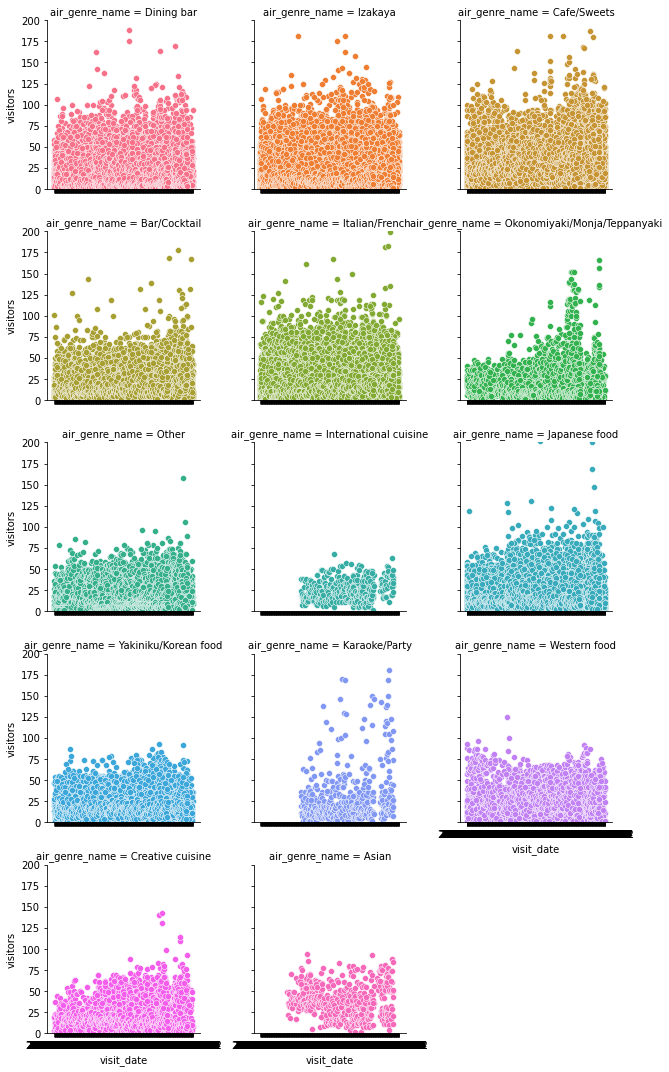

In [173]:
plt.figure(figsize=(12,10))
sns.FacetGrid(visit, col='air_genre_name',hue='air_genre_name',col_wrap=3,
             ylim=(0,200)).map(sns.scatterplot,'visit_date','visitors')
plt.show()

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

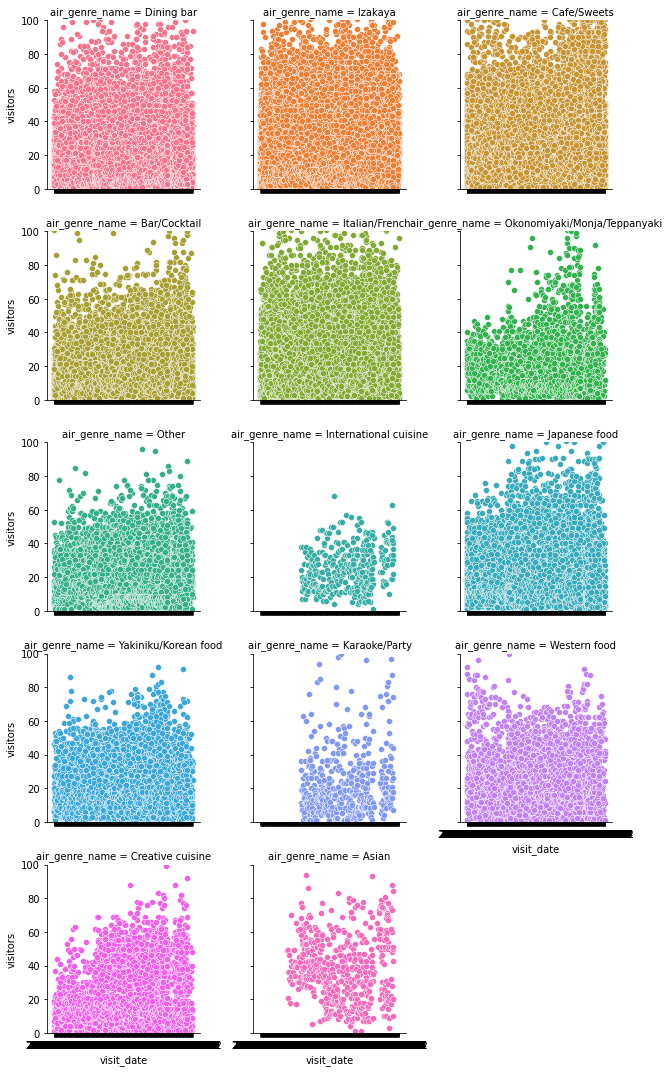

In [174]:
plt.figure(figsize=(12,10))
sns.FacetGrid(visit, col='air_genre_name',hue='air_genre_name',col_wrap=3,
             ylim=(0,100)).map(sns.scatterplot,'visit_date','visitors')
plt.show()

In [192]:
visit.iloc[:,:4]

,air_store_id,visit_date,visitors,air_genre_name
0,air_ba937bf13d40fb24,2016-01-13,25,Dining bar
1,air_ba937bf13d40fb24,2016-01-14,32,Dining bar
2,air_ba937bf13d40fb24,2016-01-15,29,Dining bar
3,air_ba937bf13d40fb24,2016-01-16,22,Dining bar
4,air_ba937bf13d40fb24,2016-01-18,6,Dining bar
...,...,...,...,...
252103,air_24e8414b9b07decb,2017-04-18,6,Other
252104,air_24e8414b9b07decb,2017-04-19,6,Other
252105,air_24e8414b9b07decb,2017-04-20,7,Other
252106,air_24e8414b9b07decb,2017-04-21,8,Other


<AxesSubplot:xlabel='air_genre_name', ylabel='visitors'>

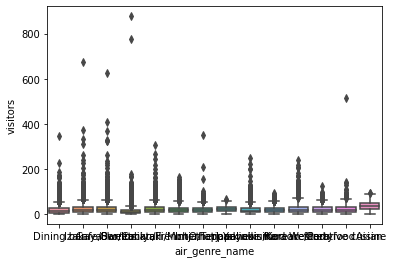

In [204]:
plt.figsize=(20,20)
plt.ylim=(0,150)
sns.boxplot(data=visit, x='air_genre_name', y='visitors')
plt.show()

<Figure size 864x720 with 0 Axes>

/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


TypeError: boxplot() got an unexpected keyword argument 'label'

<Figure size 864x720 with 0 Axes>

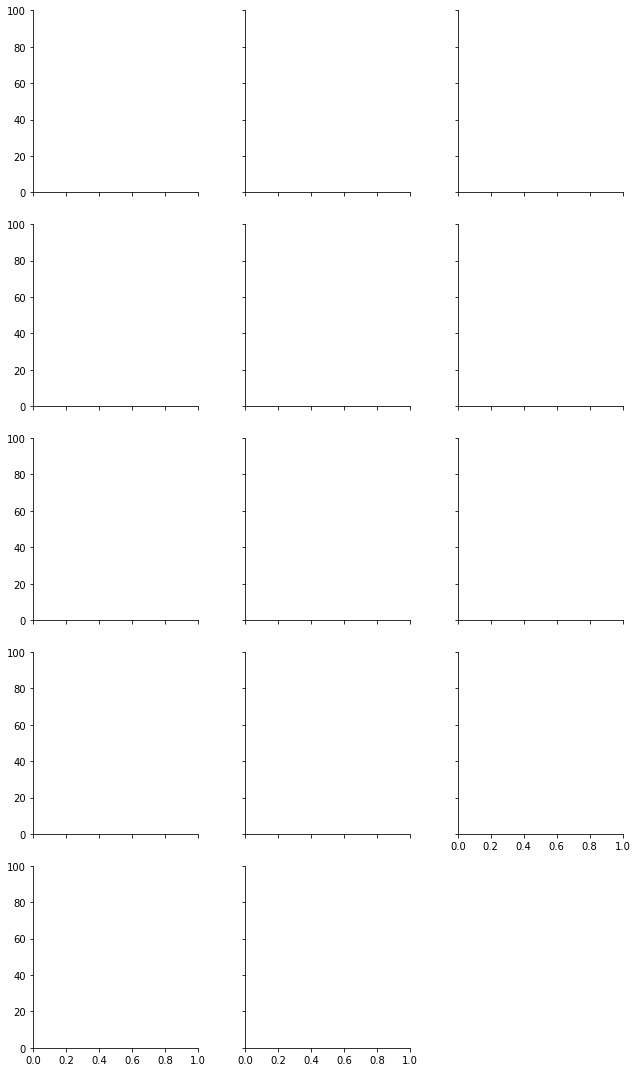

In [205]:
plt.figure(figsize=(12,10))
sns.FacetGrid(visit, col='air_genre_name',hue='air_genre_name',col_wrap=3,
             ylim=(0,100)).map(sns.boxplot,'visit_date','visitors')
plt.show()

## 가게 위치별 방문자

## air, hpg 두 데이터를 합칠 수는 없을까?

In [ ]:
data['hs'].head()

In [ ]:
data['as'].head()

In [ ]:
data['hs']['hpg_genre_name'].unique()

In [ ]:
data['as']['air_genre_name'].unique()

### air_genre_name과 hpg_genre_name을 합쳐보려는 시도..
|air_store_genre|hpg_store_genre|
|---|----|
|'Italian/French'|'Italian','French'|
|'Dining bar', ||
|'Yakiniku/Korean food'| 'Korean cuisine'| 
|'Cafe/Sweets'|'Cafe''Sweets'|
|'Izakaya'||
|'Okonomiyaki/Monja/Teppanyaki'|'Okonomiyaki/Monja/Teppanyaki'|
|'Bar/Cocktail'|'Bar/Cocktail'|
|'Japanese food', |'Japanese style', 'Udon/Soba', 'Japanese cuisine/Kaiseki','Japanese food in general','Sushi'|
|'Creative cuisine'|'Creative Japanese food'|
|'Other'||
|'Western food'|'Western food','Pasta/Pizza'|
|'International cuisine'|'Spain/Mediterranean cuisine', 'International cuisine',
|'Asian'|'Chinese general','Taiwanese/Hong Kong cuisine','Thai/Vietnamese food','Sichuan food', 'Cantonese food','Shanghai food','Dim Sum/Dumplings'|
|'Karaoke/Party'|'Karaoke','Party'|

       'Grilled meat', 'Creation', 'Shabu-shabu/Sukiyaki',
      'Seafood', 'Spain Bar/Italian Bar', , 'Bistro', 
       'Steak/Hamburger/Curry', 'Amusement bar', 

In [126]:
data['id'].head()

,air_store_id,hpg_store_id
0,air_63b13c56b7201bd9,hpg_4bc649e72e2a239a
1,air_a24bf50c3e90d583,hpg_c34b496d0305a809
2,air_c7f78b4f3cba33ff,hpg_cd8ae0d9bbd58ff9
3,air_947eb2cae4f3e8f2,hpg_de24ea49dc25d6b8
4,air_965b2e0cf4119003,hpg_653238a84804d8e7


In [162]:
id_with_store_data= pd.merge(data['id'],data['as'].iloc[:,:5],how='left')
id_with_store_data= pd.merge(id_with_store_data,data['hs'],how='left',left_on='hpg_store_id',right_on='hpg_store_id')

In [163]:
id_with_store_data.sample(10)
id_with_store_data.nunique()
id_with_store_data.isnull().sum()

,air_store_id,hpg_store_id,air_genre_name,air_area_name,latitude_x,longitude_x,hpg_genre_name,hpg_area_name,latitude_y,longitude_y,dodo,sigu
74,air_42d41eb58cad170e,hpg_70f700e5a6148b7e,Yakiniku/Korean food,Fukuoka-ken Fukuoka-shi Daimyō,33.589216,130.392813,Grilled meat,Fukuoka-ken Fukuoka-shi Daimyō,33.586969,130.392801,Fukuoka-ken,Fukuoka-ken Fukuoka-shi
120,air_9241121af22ff1d6,hpg_49dbe1fd79450e55,Izakaya,Tōkyō-to Katsushika-ku Tateishi,35.743575,139.847180,NaN,NaN,NaN,NaN,NaN,NaN
28,air_90f0efbb702d77b7,hpg_1f7bc96cada52483,Izakaya,Tōkyō-to Edogawa-ku Chūō,35.706657,139.868427,NaN,NaN,NaN,NaN,NaN,NaN
33,air_6b2268863b14a2af,hpg_7664eec3cd802c91,Italian/French,Tōkyō-to Tachikawa-shi Izumichō,35.714014,139.407843,NaN,NaN,NaN,NaN,NaN,NaN
102,air_eec5e572b9eb9c23,hpg_e6594f29f40fe2aa,Izakaya,Fukuoka-ken Fukuoka-shi Shiobaru,33.561569,130.426428,International cuisine,Fukuoka-ken Fukuoka-shi None,33.556881,130.415134,Fukuoka-ken,Fukuoka-ken Fukuoka-shi
104,air_b2a639cc7e02edf1,hpg_359983294ef1467d,Izakaya,Fukuoka-ken Fukuoka-shi Daimyō,33.589216,130.392813,Japanese style,Fukuoka-ken Fukuoka-shi Daimyō,33.586969,130.392801,Fukuoka-ken,Fukuoka-ken Fukuoka-shi
127,air_2a485b92210c98b5,hpg_dd709beb78198f38,Bar/Cocktail,Hiroshima-ken Hiroshima-shi Kokutaijimachi,34.386244,132.455018,Cafe,Hiroshima-ken Hiroshima-shi Hondōri,34.392106,132.461914,Hiroshima-ken,Hiroshima-ken Hiroshima-shi
59,air_b4f32bcc399da2b9,hpg_95875f687b36070f,Dining bar,Hiroshima-ken Hiroshima-shi Kokutaijimachi,34.386244,132.455018,International cuisine,Hiroshima-ken Hiroshima-shi Hondōri,34.392106,132.461914,Hiroshima-ken,Hiroshima-ken Hiroshima-shi
40,air_bcce1ea4350b7b72,hpg_3347c0399df81142,Izakaya,Fukuoka-ken Fukuoka-shi Hakata Ekimae,33.591358,130.414878,NaN,NaN,NaN,NaN,NaN,NaN
55,air_bebd55ed63ab2422,hpg_5014838c16a831ad,Dining bar,Shizuoka-ken Hamamatsu-shi Motoshirochō,34.710895,137.725940,NaN,NaN,NaN,NaN,NaN,NaN


air_store_id      150
hpg_store_id      150
air_genre_name     12
air_area_name      47
latitude_x         49
longitude_x        49
hpg_genre_name     16
hpg_area_name      33
latitude_y         34
longitude_y        34
dodo               11
sigu               25
dtype: int64

air_store_id       0
hpg_store_id       0
air_genre_name     0
air_area_name      0
latitude_x         0
longitude_x        0
hpg_genre_name    87
hpg_area_name     87
latitude_y        87
longitude_y       87
dodo              87
sigu              87
dtype: int64

- `store_id_relation`에 언급된 `hpg_store_id` 임에도 불구하고 결측치가 87개나 포함되어 있다.

In [152]:
id_with_hs= pd.merge(data['id'],data['hs'].iloc[:,:5],how='inner')
id_with_hs.sample(10)
id_with_hs.nunique()

,air_store_id,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude
59,air_32460819c7600037,hpg_ac318be70910278f,International cuisine,Ōsaka-fu Ōsaka-shi Awajimachi,34.686482,135.504174
0,air_a24bf50c3e90d583,hpg_c34b496d0305a809,Italian,Shizuoka-ken Hamamatsu-shi Sukenobuchō,34.721644,137.738944
36,air_ade6e836ffd1da64,hpg_cd98b0cad88f7123,International cuisine,Fukuoka-ken Kitakyūshū-shi Sunatsu,33.881500,130.887364
32,air_db80363d35f10926,hpg_878cc70b1abc76f7,Seafood,Hokkaidō Asahikawa-shi 3 Jōdōri,43.768033,142.359664
51,air_1d1e8860ae04f8e9,hpg_2fcae64da5287bf5,Spain Bar/Italian Bar,Tōkyō-to Shinjuku-ku Takadanobaba,35.712411,139.706564
45,air_c47aa7493b15f297,hpg_03795a62e1c5f1c3,Japanese style,Hiroshima-ken Hiroshima-shi Hondōri,34.392106,132.461914
20,air_e00fe7853c0100d6,hpg_d59fec517d99991f,Japanese style,Hyōgo-ken Kakogawa-shi Noguchichō Yoshino,34.752826,134.847642
40,air_324f7c39a8410e7c,hpg_03946d6b6b1e0332,Creation,Hyōgo-ken Kakogawa-shi Noguchichō Yoshino,34.752826,134.847642
31,air_5a9a6cbeeb434c08,hpg_cad1acd4374ceaa1,Seafood,Fukuoka-ken Fukuoka-shi Ōmiya,33.579734,130.401762
53,air_082908692355165e,hpg_b8715d0ac52b1763,Spain Bar/Italian Bar,Tōkyō-to Shinjuku-ku None,35.691384,139.701256


air_store_id      63
hpg_store_id      63
hpg_genre_name    16
hpg_area_name     33
latitude          34
longitude         34
dtype: int64

In [154]:
id_with_hs.isnull().sum()

air_store_id      0
hpg_store_id      0
hpg_genre_name    0
hpg_area_name     0
latitude          0
longitude         0
dtype: int64

- 경도 소수점 둘째자리까지는 비슷함

In [ ]:
data['id'].info()

In [ ]:
data['id'][['air_genre_name','hpg_genre_name']]

In [ ]:
data['hs']['hpg_genre_name']

In [ ]:
data['hs'][data['hs']['hpg_store_id']=='hpg_168a90866d6e606d']

In [ ]:
data['as'][data['as']['air_store_id']=='air_32b02ba5dc2027f4']

In [ ]:
len(data['hs']['hpg_genre_name'].unique())

In [ ]:
data['hs'].count()

In [ ]:
data['as'].count()

In [ ]:
idf = pd.DataFrame(columns=air_store.columns)
outputid = pd.Series(sample_sub['id'].apply(lambda x:x[:-11]).unique())
air_store[air_store['air_store_id'==outputid]]

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import missingno as msno
sns.set_palette('husl',9)

In [2]:
data = {
    'tra': pd.read_csv('air_visit_data.csv'),
    'as': pd.read_csv('air_store_info.csv'),
    'hs': pd.read_csv('hpg_store_info.csv'),
    'ar': pd.read_csv('air_reserve.csv'),
    'hr': pd.read_csv('hpg_reserve.csv'),
    'id': pd.read_csv('store_id_relation.csv'),
    'tes': pd.read_csv('sample_submission.csv'),
    'hol': pd.read_csv('date_info.csv').rename(columns={'calendar_date':'visit_date'})
    }


# 6. store_id_relation

### 150개의 겹치는 가게 id

In [3]:
data['id'] 

,air_store_id,hpg_store_id
0,air_63b13c56b7201bd9,hpg_4bc649e72e2a239a
1,air_a24bf50c3e90d583,hpg_c34b496d0305a809
2,air_c7f78b4f3cba33ff,hpg_cd8ae0d9bbd58ff9
3,air_947eb2cae4f3e8f2,hpg_de24ea49dc25d6b8
4,air_965b2e0cf4119003,hpg_653238a84804d8e7
...,...,...
145,air_b8925441167c3152,hpg_0cc0abae3a8b52de
146,air_f8233ad00755c35c,hpg_098e4dd30e54fee6
147,air_6607fe3671242ce3,hpg_1004356dc8ab69ec
148,air_ccd19a5bc5573ae5,hpg_df22bf146d2c7e19


In [4]:
data['as']

,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
...,...,...,...,...,...
824,air_9bf595ef095572fb,International cuisine,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051
825,air_764f71040a413d4d,Asian,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051
826,air_10bbe8acd943d8f6,Asian,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051
827,air_7514d90009613cd6,Karaoke/Party,Hokkaidō Sapporo-shi Minami 3 Jōnishi,43.055460,141.340956


In [5]:
data['hs']

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
1,hpg_e9e068dd49c5fa00,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
2,hpg_2976f7acb4b3a3bc,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
3,hpg_e51a522e098f024c,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
4,hpg_e3d0e1519894f275,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
...,...,...,...,...,...
4685,hpg_c6ed353a48c7c93e,Sichuan food,Tōkyō-to Chiyoda-ku None,35.695780,139.768453
4686,hpg_a58d2423360b2fb4,Sichuan food,Tōkyō-to Minato-ku Roppongi,35.666137,139.733978
4687,hpg_d2021704076cdd70,Shanghai food,Tōkyō-to Chiyoda-ku None,35.695780,139.768453
4688,hpg_602472570d65e219,Spain/Mediterranean cuisine,Tōkyō-to Toshima-ku None,35.730068,139.711742


## id 기준으로 store 정보 합치기

### air_store_info에 air_store_id와 일치하는 hpg_store_id 컬럼 대입

In [6]:
data['as'] = pd.merge(data['as'], data['id'], how='inner', on=['air_store_id'])
data['as']

,air_store_id,air_genre_name,air_area_name,latitude,longitude,hpg_store_id
0,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,hpg_9b38b9e13da6da27
1,air_290e7a57b390f78e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,hpg_c5ec63f52e4a7e9e
2,air_638c35eb25e53eea,Italian/French,Fukuoka-ken Fukuoka-shi Daimyō,33.589216,130.392813,hpg_f07ec7b288165b27
3,air_fcfbdcf7b1f82c6e,Italian/French,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051,hpg_0b53e00789c2eafe
4,air_f8233ad00755c35c,Italian/French,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051,hpg_098e4dd30e54fee6
...,...,...,...,...,...,...
145,air_2cee51fa6fdf6c0d,Western food,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051,hpg_113fd6e4fa77800f
146,air_b45b8e456f53942a,Western food,Hokkaidō Sapporo-shi Minami 3 Jōnishi,43.055460,141.340956,hpg_a85b37424291216b
147,air_0a74a5408a0b8642,Western food,Hokkaidō Sapporo-shi Minami 3 Jōnishi,43.055460,141.340956,hpg_2ded824e690c414a
148,air_bedd35489e666605,Western food,Tōkyō-to Chūō-ku Tsukiji,35.670651,139.771861,hpg_8f5331198ed1781d


### 'hpg_store_id' 기준으로 air_store_info 와 hpg_store_info 합치기

In [7]:
store_merge = pd.merge(data['as'], data['hs'], how='left', on=['hpg_store_id']) 
store_merge.head(20)

,air_store_id,air_genre_name,air_area_name,latitude_x,longitude_x,hpg_store_id,hpg_genre_name,hpg_area_name,latitude_y,longitude_y
0,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,hpg_9b38b9e13da6da27,NaN,NaN,NaN,NaN
1,air_290e7a57b390f78e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,hpg_c5ec63f52e4a7e9e,NaN,NaN,NaN,NaN
2,air_638c35eb25e53eea,Italian/French,Fukuoka-ken Fukuoka-shi Daimyō,33.589216,130.392813,hpg_f07ec7b288165b27,Spain Bar/Italian Bar,Fukuoka-ken Fukuoka-shi Daimyō,33.586969,130.392801
3,air_fcfbdcf7b1f82c6e,Italian/French,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051,hpg_0b53e00789c2eafe,Italian,Tōkyō-to Shibuya-ku None,35.659214,139.699736
4,air_f8233ad00755c35c,Italian/French,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051,hpg_098e4dd30e54fee6,Spain Bar/Italian Bar,Tōkyō-to Shibuya-ku None,35.659214,139.699736
5,air_938ef91ecdde6878,Italian/French,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051,hpg_623477d346cf1822,NaN,NaN,NaN,NaN
6,air_8e492076a1179383,Italian/French,Hiroshima-ken Hiroshima-shi Kokutaijimachi,34.386245,132.455018,hpg_aee92538e1b51d5f,NaN,NaN,NaN,NaN
7,air_0867f7bebad6a649,Italian/French,Hiroshima-ken Hiroshima-shi Kokutaijimachi,34.386245,132.455018,hpg_caf1082b9f445c7b,NaN,NaN,NaN,NaN
8,air_900d755ebd2f7bbd,Italian/French,Tōkyō-to Chūō-ku Ginza,35.672114,139.770825,hpg_2864fa16b03e3813,NaN,NaN,NaN,NaN
9,air_ccd19a5bc5573ae5,Italian/French,Tōkyō-to Shinjuku-ku Kabukichō,35.693840,139.703549,hpg_df22bf146d2c7e19,NaN,NaN,NaN,NaN


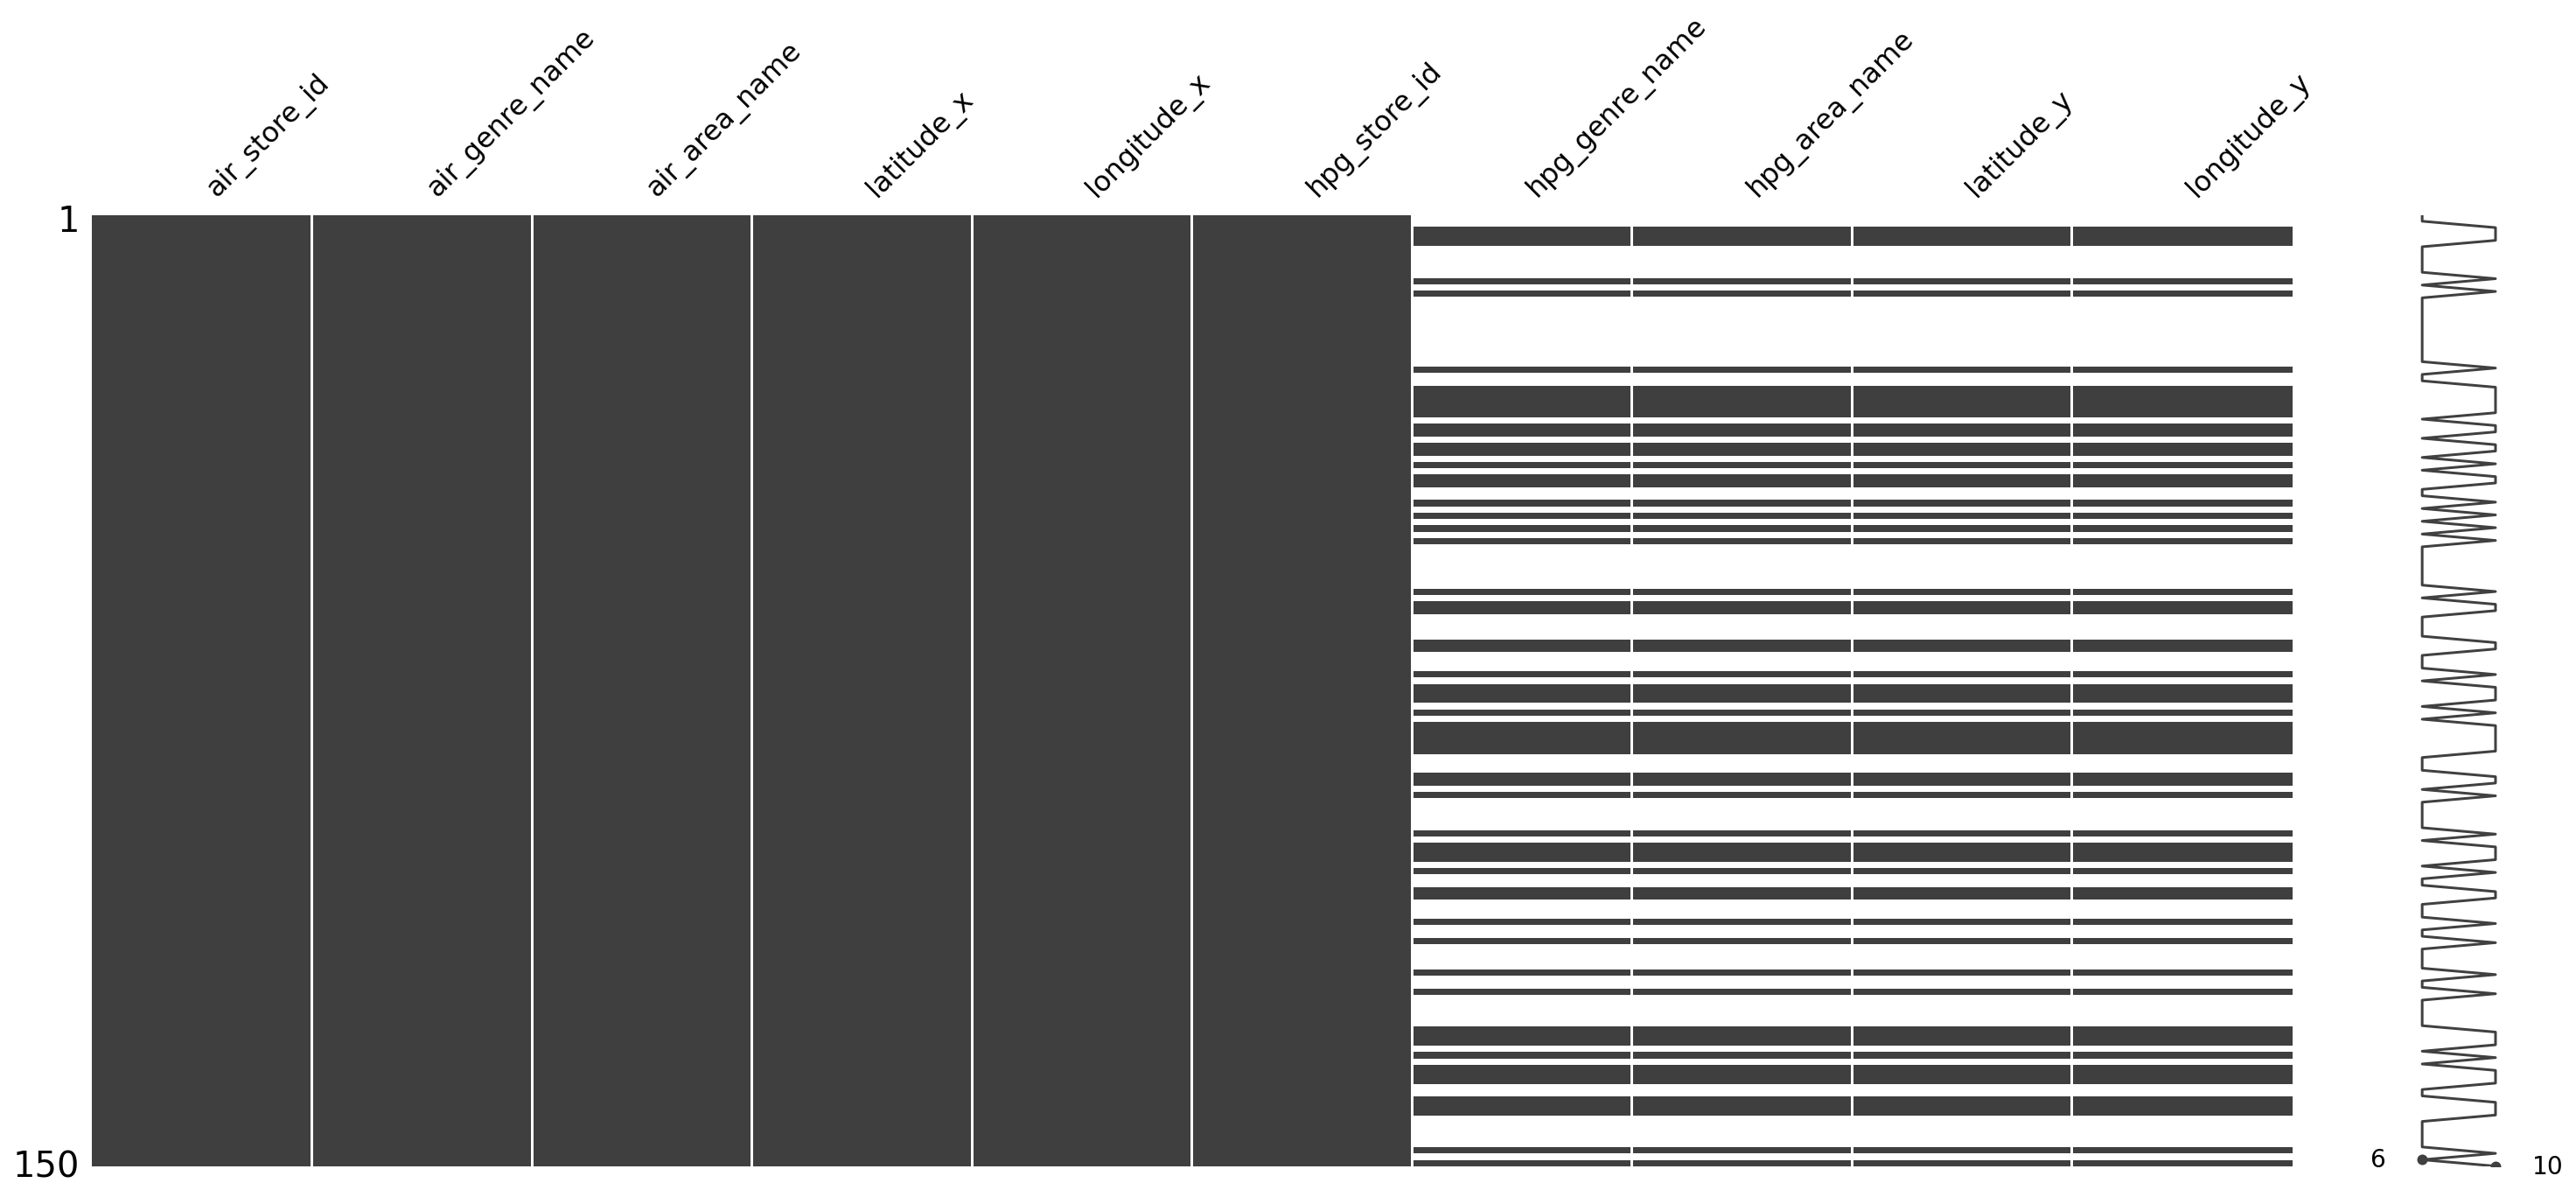

In [8]:
msno.matrix(store_merge)

In [9]:
store_merge.isnull().sum()

air_store_id       0
air_genre_name     0
air_area_name      0
latitude_x         0
longitude_x        0
hpg_store_id       0
hpg_genre_name    87
hpg_area_name     87
latitude_y        87
longitude_y       87
dtype: int64

### => hpg store 정보에 null값이 많이 보임

In [10]:
store_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 0 to 149
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   air_store_id    150 non-null    object 
 1   air_genre_name  150 non-null    object 
 2   air_area_name   150 non-null    object 
 3   latitude_x      150 non-null    float64
 4   longitude_x     150 non-null    float64
 5   hpg_store_id    150 non-null    object 
 6   hpg_genre_name  63 non-null     object 
 7   hpg_area_name   63 non-null     object 
 8   latitude_y      63 non-null     float64
 9   longitude_y     63 non-null     float64
dtypes: float64(4), object(6)
memory usage: 12.9+ KB


### 그 중 Null값인 row만 확인

In [11]:
store_null =store_merge.loc[store_merge["hpg_genre_name"].isnull()]
store_null

,air_store_id,air_genre_name,air_area_name,latitude_x,longitude_x,hpg_store_id,hpg_genre_name,hpg_area_name,latitude_y,longitude_y
0,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,hpg_9b38b9e13da6da27,NaN,NaN,NaN,NaN
1,air_290e7a57b390f78e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,hpg_c5ec63f52e4a7e9e,NaN,NaN,NaN,NaN
5,air_938ef91ecdde6878,Italian/French,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051,hpg_623477d346cf1822,NaN,NaN,NaN,NaN
6,air_8e492076a1179383,Italian/French,Hiroshima-ken Hiroshima-shi Kokutaijimachi,34.386245,132.455018,hpg_aee92538e1b51d5f,NaN,NaN,NaN,NaN
7,air_0867f7bebad6a649,Italian/French,Hiroshima-ken Hiroshima-shi Kokutaijimachi,34.386245,132.455018,hpg_caf1082b9f445c7b,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
143,air_4c727b55acdee495,Creative cuisine,Hyōgo-ken Himeji-shi Yasuda,34.815149,134.685353,hpg_26d20b9f926ff5e9,NaN,NaN,NaN,NaN
144,air_fea5dc9594450608,Other,Shizuoka-ken Hamamatsu-shi Motoshirochō,34.710895,137.725940,hpg_6507818140022452,NaN,NaN,NaN,NaN
145,air_2cee51fa6fdf6c0d,Western food,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051,hpg_113fd6e4fa77800f,NaN,NaN,NaN,NaN
146,air_b45b8e456f53942a,Western food,Hokkaidō Sapporo-shi Minami 3 Jōnishi,43.055460,141.340956,hpg_a85b37424291216b,NaN,NaN,NaN,NaN


In [12]:
data['hs'].loc[data['hs']['hpg_store_id']=='hpg_9b38b9e13da6da27']

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude


In [13]:
data['as'].loc[data['as']['air_store_id']=='air_7cc17a324ae5c7dc']

,air_store_id,air_genre_name,air_area_name,latitude,longitude,hpg_store_id
0,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,hpg_9b38b9e13da6da27


### => hpg store 정보가 없는  hpg store id 들이 존재했기 때문..
### => 같은 가게인데도 air_store_info에는 존재하고 hpg_store_info 에는 존재하지 않는 경우가 있다.

In [14]:
#store_null['hpg_store_id'][5]

***

# 7. date_info

In [15]:
data['hol']

,visit_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0
...,...,...,...
512,2017-05-27,Saturday,0
513,2017-05-28,Sunday,0
514,2017-05-29,Monday,0
515,2017-05-30,Tuesday,0


In [16]:
# 휴일만
holiday=data['hol'].loc[data['hol']['holiday_flg'] ==1]
holiday

,visit_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
10,2016-01-11,Monday,1
41,2016-02-11,Thursday,1
79,2016-03-20,Sunday,1
80,2016-03-21,Monday,1
119,2016-04-29,Friday,1
123,2016-05-03,Tuesday,1
124,2016-05-04,Wednesday,1


In [17]:
holiday['day_of_week'].value_counts()  # 공휴일인 날의 요일 분포 확인 (공휴일은 월,화인 날이 많았다.)

Monday       9
Thursday     7
Saturday     5
Friday       5
Sunday       4
Wednesday    3
Tuesday      2
Name: day_of_week, dtype: int64

In [18]:
# 날짜 데이터 타입으로 변경
data['hol']['visit_date'] = pd.to_datetime(data['hol']['visit_date'])

In [19]:
# 4월말에서 5월의 데이터를 2016년/2017년 따로 추출
holidays16 = data['hol'][((data['hol']['visit_date'] >'2016-04-15') & (data['hol']['visit_date'] < '2016-06-01'))]
holidays17 = data['hol'][((data['hol']['visit_date'] >'2017-04-15') & (data['hol']['visit_date'] < '2017-06-01'))]

In [20]:
holidays16

,visit_date,day_of_week,holiday_flg
106,2016-04-16,Saturday,0
107,2016-04-17,Sunday,0
108,2016-04-18,Monday,0
109,2016-04-19,Tuesday,0
110,2016-04-20,Wednesday,0
111,2016-04-21,Thursday,0
112,2016-04-22,Friday,0
113,2016-04-23,Saturday,0
114,2016-04-24,Sunday,0
115,2016-04-25,Monday,0


## 공휴일과 아닌 날의 count 비교

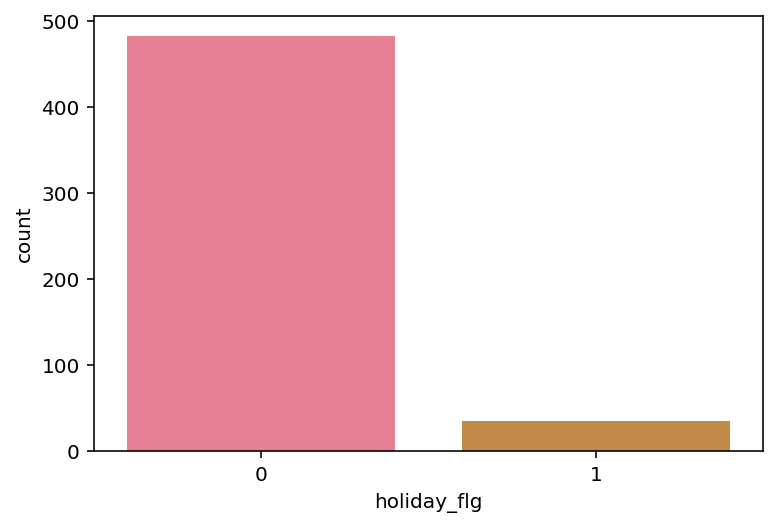

In [21]:
sns.countplot(x="holiday_flg",data = data['hol']) 

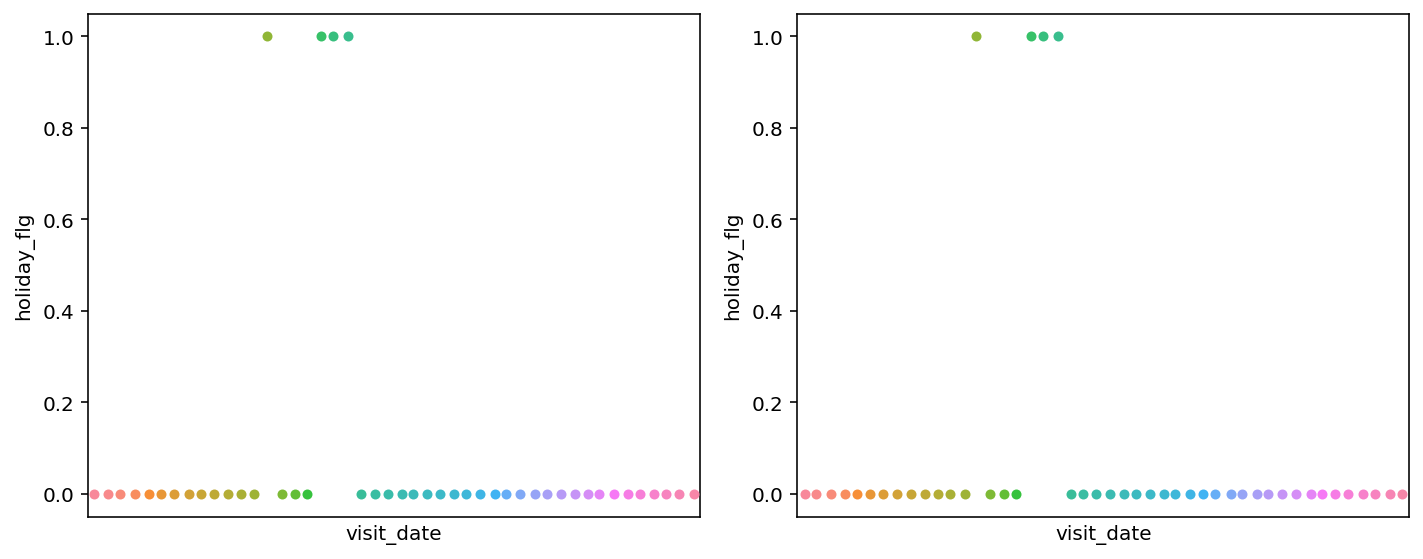

In [22]:
fig, (ax1, ax2) = plt.subplots(ncols=2,figsize=(10,4))
plt2 = sns.stripplot(x='visit_date',y='holiday_flg',data=holidays16, ax=ax1)
plt2.set_xticks([])

plt3 = sns.stripplot(x='visit_date',y='holiday_flg',data=holidays17, ax=ax2)
plt3.set(xticks=[])

plt.tight_layout()

- 2016년 4월 말과 5월은 2017년과 휴일이 같다. (4/29, 5/3,5/4,5/5)
- data에서 휴일의 비율은 대략 7%이다.

## 공휴일여부에 따른 방문객평균

In [23]:
data['hol']

,visit_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0
...,...,...,...
512,2017-05-27,Saturday,0
513,2017-05-28,Sunday,0
514,2017-05-29,Monday,0
515,2017-05-30,Tuesday,0


In [24]:
data['tra']

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6
...,...,...,...
252103,air_24e8414b9b07decb,2017-04-18,6
252104,air_24e8414b9b07decb,2017-04-19,6
252105,air_24e8414b9b07decb,2017-04-20,7
252106,air_24e8414b9b07decb,2017-04-21,8


In [25]:
data['tra']['visit_date'] = pd.to_datetime(data['tra']['visit_date'])

In [26]:
tra_hol_merge = pd.merge(data['tra'], data['hol'], how='left', on=['visit_date'])
tra_hol_merge

,air_store_id,visit_date,visitors,day_of_week,holiday_flg
0,air_ba937bf13d40fb24,2016-01-13,25,Wednesday,0
1,air_ba937bf13d40fb24,2016-01-14,32,Thursday,0
2,air_ba937bf13d40fb24,2016-01-15,29,Friday,0
3,air_ba937bf13d40fb24,2016-01-16,22,Saturday,0
4,air_ba937bf13d40fb24,2016-01-18,6,Monday,0
...,...,...,...,...,...
252103,air_24e8414b9b07decb,2017-04-18,6,Tuesday,0
252104,air_24e8414b9b07decb,2017-04-19,6,Wednesday,0
252105,air_24e8414b9b07decb,2017-04-20,7,Thursday,0
252106,air_24e8414b9b07decb,2017-04-21,8,Friday,0


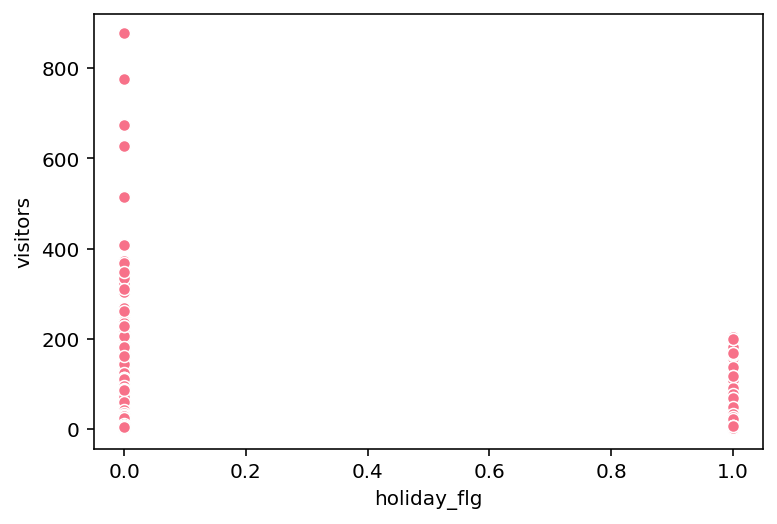

In [27]:
sns.scatterplot(x='holiday_flg',y='visitors',data=tra_hol_merge)

* 방문객이 400명을 넘는 경우는 공휴일이 아닌 날에 많이 존재함.

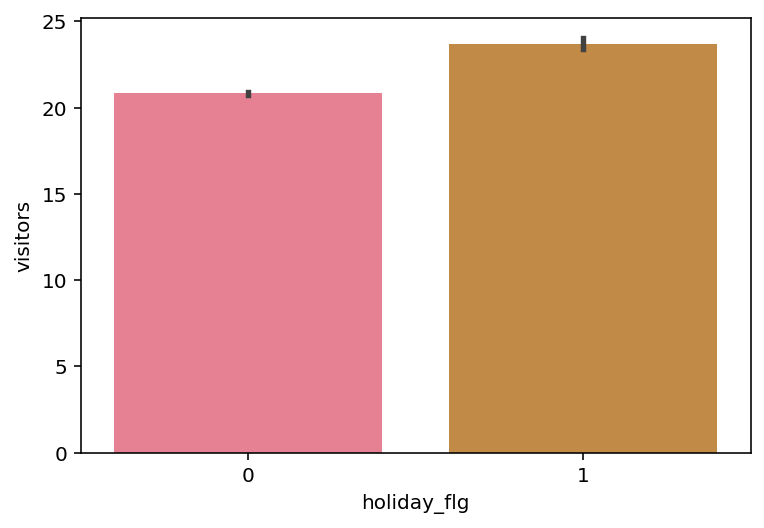

In [28]:
sns.barplot(x='holiday_flg',y='visitors',data=tra_hol_merge)

* 하지만 평균 방문자수는 공휴일일때 더 많다.

### 공휴일 요일에 따른 방문자평균

In [29]:
tra_holiday_merge = pd.merge(data['tra'],data['hol'], how='left', on=['visit_date'])
tra_holiday_merge

,air_store_id,visit_date,visitors,day_of_week,holiday_flg
0,air_ba937bf13d40fb24,2016-01-13,25,Wednesday,0
1,air_ba937bf13d40fb24,2016-01-14,32,Thursday,0
2,air_ba937bf13d40fb24,2016-01-15,29,Friday,0
3,air_ba937bf13d40fb24,2016-01-16,22,Saturday,0
4,air_ba937bf13d40fb24,2016-01-18,6,Monday,0
...,...,...,...,...,...
252103,air_24e8414b9b07decb,2017-04-18,6,Tuesday,0
252104,air_24e8414b9b07decb,2017-04-19,6,Wednesday,0
252105,air_24e8414b9b07decb,2017-04-20,7,Thursday,0
252106,air_24e8414b9b07decb,2017-04-21,8,Friday,0


In [30]:
onlyhol=tra_holiday_merge.loc[tra_holiday_merge['holiday_flg']==1]

In [31]:
pvt3=onlyhol.groupby(['day_of_week'])['visitors'].mean().reset_index()

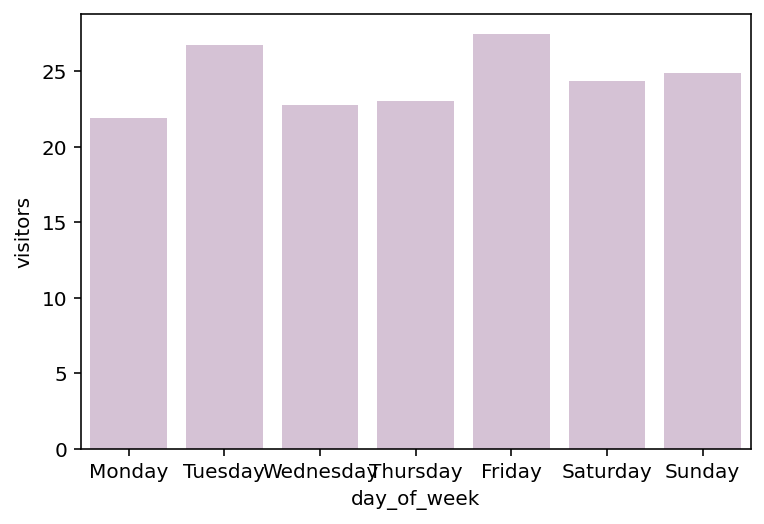

In [32]:
sns.barplot(pvt3['day_of_week'] ,pvt3['visitors'],color='thistle',order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday','Sunday'])

* 화요일,금요일이 공휴일일때, 평균방문자수가 제일 많았다.

## 공휴일여부에 따른 air예약자 평균

In [33]:
data['ar']

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5
...,...,...,...,...
92373,air_db4b38ebe7a7ceff,2017-05-29 18:00:00,2017-04-17 19:00:00,6
92374,air_1033310359ceeac1,2017-05-30 23:00:00,2017-04-19 17:00:00,8
92375,air_877f79706adbfb06,2017-05-31 20:00:00,2017-04-12 23:00:00,3
92376,air_900d755ebd2f7bbd,2017-05-31 20:00:00,2017-04-19 16:00:00,10


In [34]:
data['ar']['visit_datetime'] = pd.to_datetime(data['ar']['visit_datetime'])
data['ar']['visit_datetime'] = data['ar']['visit_datetime'].dt.date

In [35]:
data['ar']=data['ar'].rename(columns={
            'visit_datetime': 'visit_date'
        })
data['ar']['visit_date'] = pd.to_datetime(data['ar']['visit_date'])

In [36]:
ar_hol_merge = pd.merge(data['ar'], data['hol'], how='left', on=['visit_date'])
ar_hol_merge

,air_store_id,visit_date,reserve_datetime,reserve_visitors,day_of_week,holiday_flg
0,air_877f79706adbfb06,2016-01-01,2016-01-01 16:00:00,1,Friday,1
1,air_db4b38ebe7a7ceff,2016-01-01,2016-01-01 19:00:00,3,Friday,1
2,air_db4b38ebe7a7ceff,2016-01-01,2016-01-01 19:00:00,6,Friday,1
3,air_877f79706adbfb06,2016-01-01,2016-01-01 16:00:00,2,Friday,1
4,air_db80363d35f10926,2016-01-01,2016-01-01 01:00:00,5,Friday,1
...,...,...,...,...,...,...
92373,air_db4b38ebe7a7ceff,2017-05-29,2017-04-17 19:00:00,6,Monday,0
92374,air_1033310359ceeac1,2017-05-30,2017-04-19 17:00:00,8,Tuesday,0
92375,air_877f79706adbfb06,2017-05-31,2017-04-12 23:00:00,3,Wednesday,0
92376,air_900d755ebd2f7bbd,2017-05-31,2017-04-19 16:00:00,10,Wednesday,0


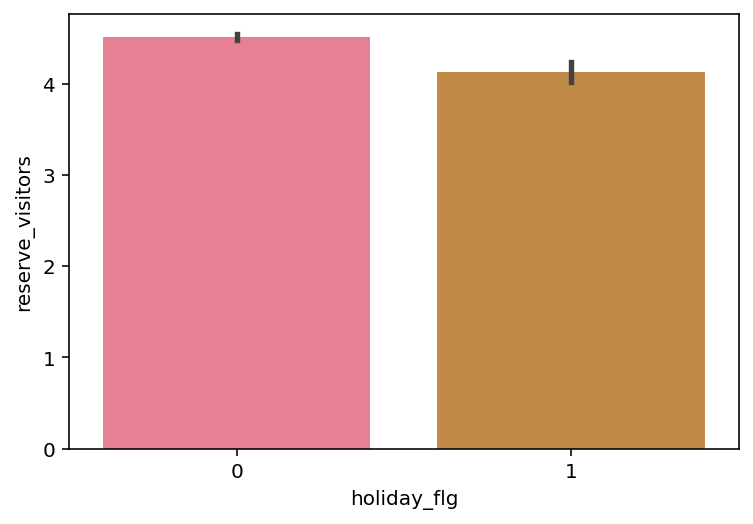

In [37]:
sns.barplot(x='holiday_flg',y='reserve_visitors',data=ar_hol_merge)

* air 평균 예약자 수는 공휴일이 아닌 날에 더 많다.

## 공휴일여부에 따른 hpg예약자 평균

In [38]:
data['hr']

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2
3,hpg_24bb207e5fd49d4a,2016-01-01 17:00:00,2016-01-01 11:00:00,5
4,hpg_25291c542ebb3bc2,2016-01-01 17:00:00,2016-01-01 03:00:00,13
...,...,...,...,...
2000315,hpg_2b293477ea4642fb,2017-05-31 20:00:00,2017-04-19 07:00:00,2
2000316,hpg_f922aeca48ca5a29,2017-05-31 20:00:00,2017-03-19 00:00:00,3
2000317,hpg_e9151de687b93aa3,2017-05-31 21:00:00,2017-04-14 20:00:00,49
2000318,hpg_fae6c96189b4a122,2017-05-31 21:00:00,2017-04-19 17:00:00,9


In [39]:
data['hr']['visit_datetime'] = pd.to_datetime(data['hr']['visit_datetime'])
data['hr']['visit_datetime'] = data['hr']['visit_datetime'].dt.date

In [40]:
data['hr']=data['hr'].rename(columns={
            'visit_datetime': 'visit_date'
        })
data['hr']['visit_date'] = pd.to_datetime(data['hr']['visit_date'])

In [41]:
hr_hol_merge = pd.merge(data['hr'], data['hol'], how='left', on=['visit_date'])
hr_hol_merge

,hpg_store_id,visit_date,reserve_datetime,reserve_visitors,day_of_week,holiday_flg
0,hpg_c63f6f42e088e50f,2016-01-01,2016-01-01 09:00:00,1,Friday,1
1,hpg_dac72789163a3f47,2016-01-01,2016-01-01 06:00:00,3,Friday,1
2,hpg_c8e24dcf51ca1eb5,2016-01-01,2016-01-01 14:00:00,2,Friday,1
3,hpg_24bb207e5fd49d4a,2016-01-01,2016-01-01 11:00:00,5,Friday,1
4,hpg_25291c542ebb3bc2,2016-01-01,2016-01-01 03:00:00,13,Friday,1
...,...,...,...,...,...,...
2000315,hpg_2b293477ea4642fb,2017-05-31,2017-04-19 07:00:00,2,Wednesday,0
2000316,hpg_f922aeca48ca5a29,2017-05-31,2017-03-19 00:00:00,3,Wednesday,0
2000317,hpg_e9151de687b93aa3,2017-05-31,2017-04-14 20:00:00,49,Wednesday,0
2000318,hpg_fae6c96189b4a122,2017-05-31,2017-04-19 17:00:00,9,Wednesday,0


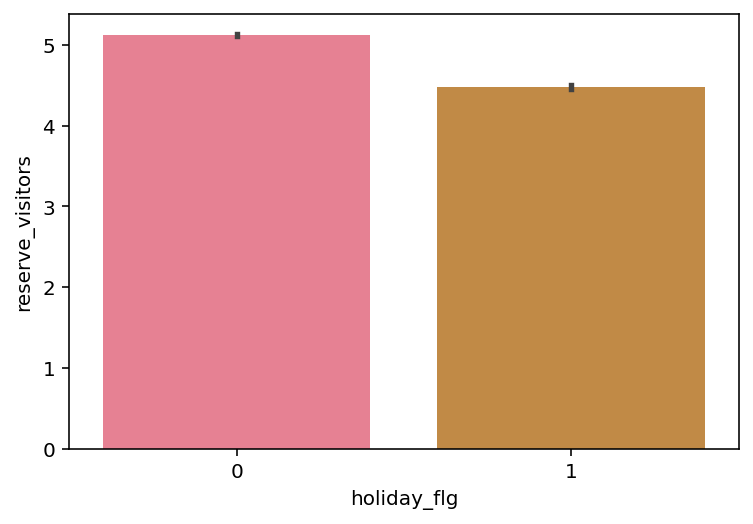

In [42]:
sns.barplot(x='holiday_flg',y='reserve_visitors',data=hr_hol_merge)

* hpg 평균 예약자 수는 공휴일이 아닌 날에 더 많다.